# Attack attempt, using a cGAN to train D and FGSM to refine D

## Imports

In [1]:
import tensorflow as tf
# tf.enable_eager_execution() # default for TF 2.0

tf.keras.backend.clear_session()  # For easy reset of notebook state.
from tensorflow import keras  # Import the tf version of keras.
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, \
                                    LeakyReLU, Conv2DTranspose, Reshape
# import keras.backend as K
from tensorflow.keras.datasets import mnist

print('TF', tf.__version__)
print('Keras', keras.__version__)

TF 2.1.0
Keras 2.2.4-tf


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tqdm
import pickle
from glob import glob
from pprint import pprint

import os.path
import shutil
import math
import random
from copy import copy, deepcopy

In [3]:
# Setting seeds for reproducibility 
# np.random.seed(0)
# tf.random.set_seed(0)

# Enlargen plots
plt.rcParams['figure.figsize'] = [10, 5]

## Parameters

In [4]:
# EASY_MODE: if True, Split Learning NN is used as the Discriminator in the GAN. This is good for testing, but
# bypasses the black-box paradigm! Use with caution
EASY_MODE = False

# Black-box params (optimized for MNIST)
depth = 9
filters = 33
dense = 110
num_classes = 10

# Input image dimensions
img_rows, img_cols = 28, 28
target_rows, target_cols = 28, 28    # governed by the chosen model
input_shape = (target_rows, target_cols, 1)

# Attack params:
attack_params = {
    'our_class': 0,                             # the label indices that we want to preserve (and the data we own)
    'attacker_clients': 5,                      # attacker controls X number of clients and their data
    'attack_classes': [1],                      # the label(s) we want to poison
    'flip_to': [7],                             # must be len(attack_classes) - flips the target label ('1') to new class ('7')
    'batch_size': 25,
    'attack_clients_list': list(range(0, 30, 3)) + [50, 100], # list(np.arange(0, 3, 0.5))
#     'num_clients': 1000,
    'prime_trigger': 0.00, #0.11                # the D test accuracy that, after which, we will move on from priming
    'prime_first_iteration': True,              # whether to always prime on the first iteration
    'prime_by_ckpt': True,                      # whether to prime manually (False) or by loading a checkpoint file (True)
    'prime_cgan_by_ckpt': False,                # whether to load a pretrained cGAN from default/ or start from scratch (False)
    'attack_trigger': 0.8,                      # the D accuracy (wrt Black-box) that, after which, we will commence an attack
    'd_refinement_batch_num': 3,                # number of batches to refine D with: G -> BB <-> D
    'd_refinement_batch_size': 100,             # number of attack images in each refinement batch: G -> BB <-> D
    'train_dataset': None,                      # attack dataset - fixed in the beginning by choosing the attacking clients
                                                # - this is the only data we have access to throughout the training process
    'attacks_per_train_step': 1,                # how many times to attack per epoch
    'prime_exit_trigger': 1.0,                  # how good D has to be on the current blackbox model to exit priming
    'refine_exit_trigger': 1.0,                 # how good D has to be after refinement*
    'train_bb_every_n_its': 6,                  # only train the BB model while querying if (it % train_bb_every_n_its == 0)
    'cgan_query_every_n_its': 1,                # only query BB with cGAN every N iterations
    'refine_using_fgsm': True,                  # use the uGAN to generate images to refine D with via uG -> BB -> D
    'accumulate_g_queries': True,               # whether to keep uGAN imgs every iteration, or to just use most recent (False)
    'flush_g_queries_every_bb_train': False,    # whether to keep uGAN imgs after new BB is trained, or preserved them (False)
    'reset_g_every_bb_train': False,            # whether to reset G back to init every time we train the BB model
}

# Split Learning training params:
split_training_params = {
    'minibatch_size': None,                     # number of samples to operate on at one time
                                                #  - can vary to optimize computing requirements
                                                #  - if None, will evaluate the client's whole batch regardless of its size
    'apply_gradients_after': 20,                # after averaging the gradients from X clients, we will apply them to the model
    'epochs': 1,                                # number of epochs to train for
    'shuffle_clients': True,                    # whether to shuffle the clients during training
    'eval_batch_size': 256,                     # batch size when evaluating test set (not split by clients),
    'train_dataset': None,                      # training set - indexed by client
    'test_dataset': None,                       # testing set - not batched
    'batch_limit': None,                        # how many batches to train on, maximum, per epoch
    'ckpt_folder': "blackbox_checkpoint",       # folder where to store the checkpoints
    'start_id': 'split_start_model',            # start piece
    'middle_id': 'split_middle_model',          # middle piece
    'end_id': 'split_end_model',                # end piece
    'full_id': 'split_model',                   # full model name
}

# cGAN training params:
cgan_training_params = {
    'minibatch_size': split_training_params['minibatch_size'],
    'extra_depth': 3,                           # number of extra middle layers to put in the D of cGAN
    'start_id': 'd_start_model',                # start piece
    'middle_id': 'd_middle_model',              # middle piece
    'end_id': 'd_end_model',                    # end piece
    'full_id': 'd_model',                       # full model name
    'use_bb_ends': True,                        # whether to share the weights of the start and end piece from the BB model
    'batch_size': 256,                          # number of images to generate from cG at once
    'noise_dim': 100,                           # noise vector for cG
    'epochs': 8,                                # number of epochs to train cGAN
    'use_blackbox': False,                      # if True, copies the Blackbox model into D (easy check)
    'd_ckpt_folder': "discriminator_checkpoint",# folder where to store the d checkpoints
    'bb_ckpt_folder': "blackbox_checkpoint",    # folder where the blackbox default ckpt is kept
    'g_ckpt_folder': "generator_checkpoint",    # folder where to store the g checkpoints
    'batches_per_epoch': 100,                   # number of batches to train on per epoch
    'd_trigger': 0.98,                          # train D if g_accuracy is >= X
    'g_trigger': 1.01,                          # train G if g_accuracy is < X
    'loop_times': 0,                            # number of times to apply softmax -> onehot encoding
    'uncertain_loop_times': 1,                  # number to use in the uncertain_loss used by D
    'softmax_power': 2,                         # number used in softmax -> onehot encoding operation
    'd_reset_percentage': 1.0,                  # reset D if the test d_accuracy dips below X% of the original accuracy
    'early_stop_trigger': 5,                    # stop training early, if g_accuracy has not improved for X epochs
    'stop_sensitivity': 0.02,                   # "no improvement" is when the g_accuracy has not moved more than X% from prev
    'g_nudge_trigger': 3,                       # if "no improvement" for X epochs, turn on D for one turn
    'g_nudge_probability': 0.20,                # probability of nudging this sample, if enabled
    'counter_nudge': True,                      # whether to train an extra epoch when coming out of training right after nudge
    'd_priming_epoch_limit': 1000,              # number of epochs to stop at for priming
    'd_refine_epoch_limit': 500,                # number of epochs to stop at for refining D
    'save_best_g': False,                       # whether to save the best G during training, or to just use the last one
    'd_restore_after_nudge': True,              # whether to restore D back to normal at the end of the epoch if it was nudged
    'reset_g_every_it': False,                  # whether to restore cG back to init at the end of Step 5 if not -> Step 6
}

# FGSM training params:
fgsm_training_params = {
    'epsilon': 0.5,
    'norm': 'L1',                                 # can be L1, Inf
}

# Data parsing params
clients_per_class = 100                         # number of clients per label. Each client only has access to one label
                                                # - each unique class is divided into X number of subsets

# Dataset params
separated_folder = "./separated_dataset"
os.makedirs(separated_folder, exist_ok=True)
separated_train_path = os.path.join(separated_folder, "train_separated.pkl")
separated_test_path = os.path.join(separated_folder, "test_separated.pkl")

In [5]:
# TODO:
# Parameters for Label Poisoning:

attack_params['attacker_clients'] = 95
num_poisoning_iterations = 1

training_classes_to_keep = [0, 1, 2, 3, 4, 5, 6, 8, 9]
# training_classes_to_keep = []

## Load Data

In [6]:
# The data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255    # range is [0, 1]
x_test /= 255     # range is [0, 1]

if target_rows != img_rows or target_cols != img_cols:
    # resize x_train
    x_train_resized = []
    for x_ in x_train:
        # scale image to be the same WxH as we need:
        x_ = cv2.resize(x_, dsize=(target_rows, target_cols), interpolation=cv2.INTER_CUBIC)
        x_train_resized.append(x_)
    x_train = np.asarray(x_train_resized)

    # resize x_test
    x_test_resized = []
    for x_ in x_test:
        # scale image to be the same WxH as we need:
        x_ = cv2.resize(x_, dsize=(target_rows, target_cols), interpolation=cv2.INTER_CUBIC)
        x_test_resized.append(x_)
    x_test = np.asarray(x_test_resized)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [7]:
# summary of data shapes:
print('X:', x_train.shape, x_test.shape)
print('y:', y_train.shape, y_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

BUFFER_SIZE = x_train.shape[0]

X: (60000, 28, 28, 1) (10000, 28, 28, 1)
y: (60000, 10) (10000, 10)
60000 train samples
10000 test samples


#### Separate the data by class

In [8]:
# Separating the data by class
if os.path.isfile(separated_train_path):
    with open(separated_train_path, 'rb') as f:
        x_train_dict, y_train_dict = pickle.load(f)
        print('loaded training seperation')
else:
    x_train_dict = {}
    y_train_dict = {}
    for target_label in tqdm_notebook(range(10)):
        x_train_dict[target_label] = []
        y_train_dict[target_label] = []
        for i, label in enumerate(y_train):
            if list(label).index(1) == target_label:
                x_train_dict[target_label].append(x_train[i])
                y_train_dict[target_label].append(y_train[i])
    
    with open(separated_train_path, 'wb') as f:
        pickle.dump([x_train_dict, y_train_dict], f)
        print('saved training seperation')

if os.path.isfile(separated_test_path):
    with open(separated_test_path, 'rb') as f:
        x_test_dict, y_test_dict = pickle.load(f)
        print('loaded testing seperation')
else:
    x_test_dict = {}
    y_test_dict = {}
    for target_label in tqdm_notebook(range(10)):
        x_test_dict[target_label] = []
        y_test_dict[target_label] = []
        for i, label in enumerate(y_test):
            if list(label).index(1) == target_label:
                x_test_dict[target_label].append(x_test[i])
                y_test_dict[target_label].append(y_test[i])

    with open(separated_test_path, 'wb') as f:
        pickle.dump([x_test_dict, y_test_dict], f)
        print('saved testing seperation')
    
# convert dicts to lists
x_train_seperated = [np.array(x_train_dict[i]) for i in range(10)]
y_train_seperated = [np.array(y_train_dict[i]) for i in range(10)]

x_test_seperated = [np.array(x_test_dict[i]) for i in range(10)]
y_test_seperated = [np.array(y_test_dict[i]) for i in range(10)]

loaded training seperation
loaded testing seperation


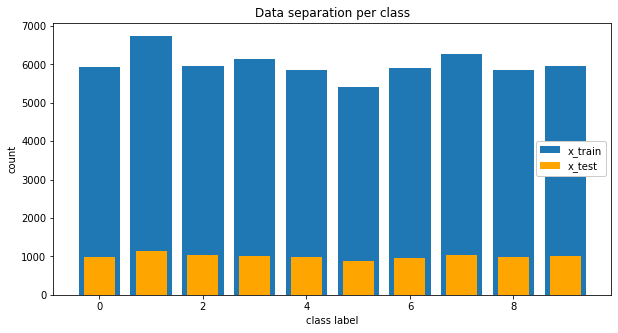

In [9]:
# summary of data shapes:
plt.figure()
plt.title('Data separation per class')
plt.bar(x_train_dict.keys(), [len(v) for v in x_train_dict.values()], color='tab:blue')
plt.bar(x_test_dict.keys(), [len(v) for v in x_test_dict.values()], color='orange', width=0.6)
plt.legend(['x_train', 'x_test'], loc='center right', framealpha=1.0)
plt.xlabel('class label')
plt.ylabel('count')
plt.show()

#### Separate the data into batches for clients to use

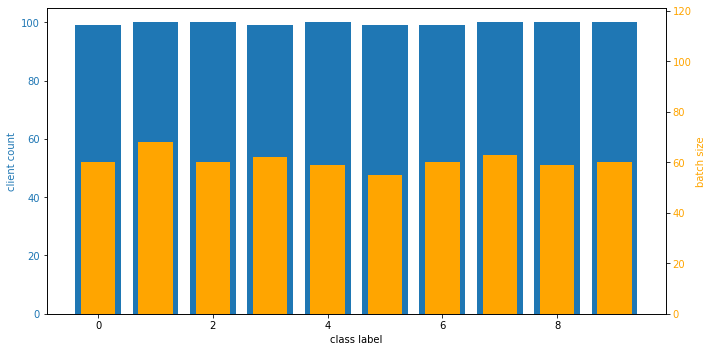

Clients per class:  99.6 ~= 100
Total number of clients: 996
Average batch size: 60


In [10]:
# Separate the data into a long list of batches, each batch representing a client training with that batch of images.
# After each batch, a new client will have the opportunity to train their batch of images.
# Batches are shuffled to simulate many clients training the model at once.

client_counts = {}
batch_sizes = {}
x_batches = []
y_batches = []

def ceil(a,b):
    return -(-a//b)

for class_idx in range(len(x_train_seperated)):
    # Get batches from class data:
    n_samples_per_class = len(x_train_seperated[class_idx])
    samples_per_client = n_samples_per_class / clients_per_class
    better_batch_size = int(math.ceil(samples_per_client))

    count = 0
    for i in range(ceil(n_samples_per_class, better_batch_size)):
        x_batches.append((class_idx, x_train_seperated[class_idx][i * better_batch_size: (i+1) * better_batch_size]))
        y_batches.append((class_idx, y_train_seperated[class_idx][i * better_batch_size: (i+1) * better_batch_size]))
        count += 1
    client_counts[class_idx] = count
    batch_sizes[class_idx] = better_batch_size
        
# double check that the clients_per_class is upheld per class
# (blue bars should be uniform, orange should change according to class):
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('class label')
ax1.set_ylabel('client count', color=color)
plt.bar(client_counts.keys(), [v for v in client_counts.values()], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'orange'
ax2.set_ylabel('batch size', color=color)  # we already handled the x-label with ax1
plt.bar(batch_sizes.keys(), [v for v in batch_sizes.values()], color=color, width=0.6)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, np.mean([v for v in batch_sizes.values()])*2)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

print('Clients per class:  {} ~= {}'.format(np.mean([v for v in client_counts.values()]), clients_per_class))
print('Total number of clients: {}'.format(np.sum([v for v in client_counts.values()])))
batch_average = int(np.mean([v for v in batch_sizes.values()]))
print('Average batch size: {}'.format(batch_average))

split_batch_size = np.floor(np.mean([v for v in batch_sizes.values()]))

#### Define the attacker's dataset

In [11]:
x_batches_filtered_i = [i for i, batch in enumerate(x_batches) if batch[0] == attack_params['our_class']]
y_batches_filtered_i = [i for i, batch in enumerate(y_batches) if batch[0] == attack_params['our_class']]
assert x_batches_filtered_i == y_batches_filtered_i

x_batches_filtered = list(map(x_batches.__getitem__, x_batches_filtered_i))
y_batches_filtered = list(map(y_batches.__getitem__, y_batches_filtered_i))

print('{} clients to choose from:'.format(len(x_batches_filtered)))
print('Classes of attack clients:', [f[0] for f in x_batches_filtered])
print()

attack_clients = np.random.choice(len(x_batches_filtered), attack_params['attacker_clients'], replace=False)
print('Choosing the following clients as the attackers:\n{}'.format(attack_clients))
x_attack_batches = list(map(x_batches_filtered.__getitem__, attack_clients))
y_attack_batches = list(map(y_batches_filtered.__getitem__, attack_clients))

99 clients to choose from:
Classes of attack clients: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Choosing the following clients as the attackers:
[59  2 96 23 94 64 60 17 53 54 22 70 67  0 26 72 27 51 21 43 39 93 82 85
 92  9 83 68 32 48 98 80 79 90 81 24 50 66 35 73  5 71 42 77  4 97 41 46
 16 38 76 36 87 40 61 12 11 91 18  8 63 74 52 20 65 49 95 78 31 25 13  1
 30 84 14 15 86 29 44 75 56 47 37 10 55 58 34 57 28 45  3 33 62 89 88]


In [12]:
# remove the attackers from the original training dataset
# BREAKS THE ORIGINAL X_BATCHES AND Y_BATCHES!
print('Original dataset length:', len(x_batches), len(y_batches))

x_attackers_i = list(map(x_batches_filtered_i.__getitem__, attack_clients))
y_attackers_i = list(map(y_batches_filtered_i.__getitem__, attack_clients))

x_batches = [batch for i, batch in enumerate(x_batches) if i not in x_attackers_i]
y_batches = [batch for i, batch in enumerate(y_batches) if i not in y_attackers_i]

print('New dataset length:     ', len(x_batches), len(y_batches))

Original dataset length: 996 996
New dataset length:      901 901


#### Define our datasets

In [13]:
# Batch and shuffle the data for Split Learning
split_train_dataset = (x_batches, y_batches)
split_test_dataset = (x_test, y_test)

# place into train params:
split_training_params['train_dataset'] = split_train_dataset
split_training_params['test_dataset'] = split_test_dataset

# Build attack dataset
attack_train_dataset = (x_attack_batches, y_attack_batches)
attack_params['train_dataset'] = attack_train_dataset

In [14]:
# Show min and max of the dataset (ensure you are using the right normalization)
min_ = np.inf
max_ = -np.inf
for batch in x_batches:
    min__ = np.min(batch[1])
    max__ = np.max(batch[1])
    min_ = min(min_, min__)
    max_ = max(max_, max__)
print('Min: {}; Max: {}'.format(min_, max_))

Min: 0.0; Max: 1.0


## Build Model

In [15]:
# FUNCTIONAL versions of the graphs. When calling them, you will need to specify input_layer= and training=

def start_piece(identifier, input_shape, filters=4):
    assert filters >= 1
    
    input_1 = keras.layers.Input(input_shape)
    conv1 = Conv2D(filters, kernel_size=(3, 3), activation='relu', padding='same')(input_1)
    model = keras.models.Model(inputs=[input_1], outputs=conv1)
    model._name = identifier
    
    return model

def blackbox_piece(identifier, input_shape, depth=1, filters=4):
    assert depth >= 1
    assert filters >= 1
    
    input_2 = keras.layers.Input(input_shape)
    
    # for now, we will just give the black-box all the CNN layers
    for i in range(depth-1):
        if i == 0:
            convs = Conv2D(filters, kernel_size=(3, 3), activation='relu', padding='same')(input_2)
        else:
            convs = Conv2D(filters, kernel_size=(3, 3), activation='relu', padding='same')(convs)
            
    model = keras.models.Model(inputs=[input_2], outputs=convs)
    model._name = identifier
    
    return model

def approximator_piece(identifier, input_shape, depth=1, filters=4):
    assert depth >= 1
    assert filters >= 1
    
    input_2 = keras.layers.Input(input_shape)
    
    # for now, we will just give the black-box all the CNN layers
    for i in range(depth-1):
        if i == 0:
            convs = Conv2D(filters, kernel_size=(3, 3), activation='relu', padding='same')(input_2)
        else:
            convs = Conv2D(filters, kernel_size=(3, 3), activation='relu', padding='same')(convs)
            
    model = keras.models.Model(inputs=[input_2], outputs=convs)
    model._name = identifier
    
    return model

def end_piece(identifier, input_shape, dense_breadth=128, num_classes=10):
    assert dense_breadth >= num_classes
    
    input_3 = keras.layers.Input(input_shape)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(input_3)
    drop1 = Dropout(0.25)(pool1)
    flat1 = Flatten()(drop1)
    dense1 = Dense(dense_breadth, activation='relu')(flat1)
    drop2 = Dropout(0.5)(dense1)
    dense2 = Dense(num_classes, activation='softmax')(drop2)
    
    model = keras.models.Model(inputs=[input_3], outputs=dense2)
    model._name = identifier
    
    return model

## Graph Creation

In [16]:
# Ensure the params are acceptable:
assert depth >= 1
assert filters >= 1
assert dense >= num_classes

In [17]:
class SplitLearning:
    
    def __init__(self, split_training_params):
        self.minibatch_size = split_training_params['minibatch_size']
        self.batches_per_train_step = split_training_params['apply_gradients_after']
        self.eval_batch_size = split_training_params['eval_batch_size']
        self.shuffle_clients = split_training_params['shuffle_clients']
        
        self.ckpt_folder = split_training_params['ckpt_folder']
        self.start_id = split_training_params['start_id']
        self.middle_id = split_training_params['middle_id']
        self.end_id = split_training_params['end_id']
        self.full_id = split_training_params['full_id']
        
        # define the NN model
        self.start_piece = None
        self.middle_piece = None
        self.end_piece = None
        self.model = self.blackbox_model()
        
        # define loss function
        self.cross_entropy = keras.losses.CategoricalCrossentropy(from_logits=True)
        
        # define optimizers
        self.optimizer = tf.keras.optimizers.Adam(1e-4)
        
        # define metrics
        self.acc_train_avg = None
        self.loss_train_avg = None
        
        # setup checkpointing
        self.init_ckpt()
        
        # setup ops
        self.setup_ops()
        
    ###########################################################################################
    # Black-box model
        
    def blackbox_model(self):
        # create all three models
        
        #   start piece...
        self.start_piece = start_piece(self.start_id, input_shape, filters)
        output_shape = self.start_piece.layers[-1].output_shape[1:]
        
        #   middle...
        self.middle_piece = blackbox_piece(self.middle_id, output_shape, depth, filters)
        output_shape = self.middle_piece.layers[-1].output_shape[1:]
        
        #   end piece...
        self.end_piece = end_piece(self.end_id, output_shape, dense, num_classes)
        
        # glue the three models together
        input_ = keras.layers.Input(input_shape)
        hidden1 = self.start_piece(input_)
        hidden2 = self.middle_piece(hidden1)
        output_ = self.end_piece(hidden2)
        
        # create the full model
        model = keras.models.Model(inputs=[input_], outputs=output_)
        model._name = self.full_id
        model.summary()
        
        return model
    
    def model_loss(self, y_true, y_pred):
        return self.cross_entropy(y_true, y_pred)
        
    ###########################################################################################
    # Train
    
    def setup_ops(self):
        # INSPIRED BY: https://stackoverflow.com/questions/42156957/how-to-update-model-parameters-with-accumulated-gradients
        # https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough
        
        self.tvs = self.model.trainable_variables
        self.accum_vars = [tf.Variable(tf.zeros_like(tv.initialized_value()), trainable=False) for tv in self.tvs]
        self.accum_counter = tf.Variable(0.0, trainable=False)
    
    def train(self, datasets, iteration, g_dataset=None, batch_limit=None, attack_datasets=None, attack_clients=1):
        # setup checkpointing
        self.setup_ckpt(iteration)
        
        # setup bb_dataset (stores labels if g_dataset is passed in)
        bb_dataset = []
        
        g_dataset_acc = tf.keras.metrics.Accuracy()
        
        # initialize the metrics each new epoch
        if self.acc_train_avg is not None:
            del self.acc_train_avg
        if self.loss_train_avg is not None:
            del self.loss_train_avg
        self.acc_train_avg = tf.keras.metrics.Accuracy()
        self.loss_train_avg = tf.keras.metrics.Mean()
        
        # append all datasets together for training:
        x_batches = []
        y_batches = []
        for dataset in datasets:
            x_batches_, y_batches_ = dataset
            x_batches = x_batches + x_batches_
            y_batches = y_batches + y_batches_
        # if g_dataset is not None, add those batches to the end:
        if g_dataset is not None:
            g_x_batches, g_y_batches = g_dataset
            g_batch_idxs = list(range(len(x_batches), len(x_batches)+len(g_x_batches)))
            x_batches = x_batches + g_x_batches
            y_batches = y_batches + g_y_batches
        else:
            g_batch_idxs = []
            
        # do the same thing with the attack datasets
        if attack_datasets is None:
            attack_datasets = []
        x_attack = []
        y_attack = []
        for dataset in attack_datasets:
            x_attack_, y_attack_ = dataset
            x_attack = x_attack + x_attack_
            y_attack = y_attack + y_attack_
            
#         print(len_x_attack)
#         print(len_x_attack[0])
#         print(len_x_attack[0][1])
            
        # setup progress bar
        total_batches = batch_limit if batch_limit is not None and batch_limit < len(x_batches) else len(x_batches)
        pbar = tqdm_notebook(total=total_batches)
        
        batch_idxs = list(range(len(x_batches)))
        if self.shuffle_clients:
            # shuffle the batches each time
            random.shuffle(batch_idxs)
            
        for i, batch_idx in enumerate(batch_idxs):
            x_batch = x_batches[batch_idx][1]
            y_batch = y_batches[batch_idx][1]
            
            if batch_idx in g_batch_idxs:
                # this is a g_x_batch! don't apply gradients, but store the prediction
                logit_batch = self.pred_step(x_batch)
                g_dataset_acc(tf.argmax(y_batch, 1), tf.argmax(logit_batch, 1))
                bb_dataset.append((x_batch, y_batch, logit_batch))
            else:
                self.train_step(i, x_batch, y_batch, len(batch_idxs) - 1, attack=(x_attack, y_attack), 
                                attack_clients=attack_clients)
            pbar.update(1)
            pbar.set_description('train_acc={:.2f}%'.format(self.acc_train_avg.result()*100))
            
            if batch_limit is not None and i-1 >= batch_limit:
                break
        pbar.close()
        print('train_acc={:.4f}%'.format(self.acc_train_avg.result()*100))
        print('accuracy of blackbox on G dataset: {:.4f}%'.format(g_dataset_acc.result()*100))
        
        # save checkpoints
        self.checkpoint()
        
        return bb_dataset
        
    def pred_step(self, x_batch):
        logit_batch = []
        # Iterate over the client's batch in minibatches:
        j = 0
        while(j < len(x_batch)):
            if self.minibatch_size is None:
                # use whole batch (no minibatch)
                x_minibatch = x_batch
            else:
                x_minibatch = x_batch[j:(j+self.minibatch_size)]

            logits = self.model(x_minibatch, training=True) # TODO: should this be False?
            logit_batch = logit_batch + list(logits.numpy())

            if self.minibatch_size is None:
                break
            else:
                j += self.minibatch_size
                
        return logit_batch
        
    def train_step(self, i, x_batch, y_batch, limit, attack=None, attack_clients=1):
        # Iterate over the client's batch in minibatches:
        j = 0
        while(j < len(x_batch)):
            if self.minibatch_size is None:
                # use whole batch (no minibatch)
                x_minibatch = x_batch
                y_minibatch = y_batch
            else:
                x_minibatch = x_batch[j:(j+self.minibatch_size)]
                y_minibatch = y_batch[j:(j+self.minibatch_size)]

            # run the gradients
            loss_value, grads = self.grad(x_minibatch, y_minibatch)

            # accumulate them
            self.accumulate_grads(grads)

            if self.minibatch_size is None:
                break
            else:
                j += self.minibatch_size

        # perform a train step every batches_per_train_step number of batches:
        if (i > 0 and i % self.batches_per_train_step == 0) or i == limit:
            
            if attack is not None and len(attack[0]) > 0:
                x_batches = attack[0]
                y_batches = attack[1]
                
                for b in range(len(x_batches)):
                    x_batch = x_batches[b][1]
                    y_batch = y_batches[b][1]
                
                    for i in range(attack_params['attacks_per_train_step']):
                        ##########
                        # Add attack to the grads X number of times:
                        j = 0
                        while(j < len(x_batch)):
                            if self.minibatch_size is None:
                                # use whole batch (no minibatch)
                                x_minibatch = x_batch
                                y_minibatch = y_batch
                            else:
                                x_minibatch = x_batch[j:(j+self.minibatch_size)]
                                y_minibatch = y_batch[j:(j+self.minibatch_size)]

                            # run the gradients
                            loss_value, grads = self.grad(x_minibatch, y_minibatch)

                            # accumulate them
                            self.accumulate_grads(grads, num_times=attack_clients)

                            if self.minibatch_size is None:
                                break
                            else:
                                j += self.minibatch_size
                        ##########
            
            # Run the train_step ops to update the weights based on our accumulated gradients
            self.optimize()
            self.zero_out()
    
    def grad(self, inputs, targets):
        with tf.GradientTape() as tape:
            logits = self.model(inputs, training=True)
            loss_value = self.model_loss(targets, logits)
            
        # evaluate accuracy and append acc and loss to arrays
        self.acc_train_avg(tf.argmax(targets, 1), tf.argmax(logits, 1))
        self.loss_train_avg(loss_value)
        
        return loss_value, tape.gradient(loss_value, self.model.trainable_variables)
    
    def accumulate_grads(self, grads, num_times=1):
        # add to accum_vars the new gradients
        for i, grad in enumerate(grads):
            self.accum_vars[i].assign_add(grad * num_times)
        # increment the counter by 1
        self.accum_counter.assign_add(1.0 * num_times)
        
    def optimize(self):
        # apply the gradients in accum_vars, dividing by the number in accum_counter
        self.optimizer.apply_gradients(
            [(accum_var / self.accum_counter, tv) \
                for (accum_var, tv) in zip(self.accum_vars, self.model.trainable_variables)]
        )
    
    def zero_out(self):
        # reset accum_vars and accum_counter back to 0
        for i, tv in enumerate(self.accum_vars):
            self.accum_vars[i].assign(tf.zeros_like(tv))
        self.accum_counter = tf.Variable(0.0, trainable=False)
        
    ###########################################################################################
    # Checkpoint
    
    def init_optimer(self):
        del self.optimizer
        self.optimizer = tf.keras.optimizers.Adam(1e-4)
    
    def init_ckpt(self):
        self.ckpt = tf.train.Checkpoint(optimizer=self.optimizer, model=self.model)
        self.manager = None
        self.internal_iteration = None
        self.iteration_offset = 0
        
    def setup_ckpt(self, iteration):
        # setup fresh checkpointer every new iteration
        if self.internal_iteration is None or iteration != self.internal_iteration - self.iteration_offset:
            ckpt_save_folder = os.path.join('checkpoints', 'it_{}'.format(iteration + self.iteration_offset), self.ckpt_folder)
            os.makedirs(ckpt_save_folder, exist_ok=True)
        
            if self.ckpt is not None:
                del self.ckpt
            if self.manager is not None:
                del self.manager

            self.ckpt = tf.train.Checkpoint(optimizer=self.optimizer, model=self.model)
            self.manager = tf.train.CheckpointManager(self.ckpt, ckpt_save_folder, max_to_keep=1)
            self.internal_iteration = iteration + self.iteration_offset
    
    def checkpoint(self):
        save_path = self.manager.save()
        print("Saved checkpoint: {}".format(save_path))
        self.save_all_models(save_path)
        
    def save_all_models(self, save_path):
        # in addition to checkpointing, save all of the models into their own ckpt files
        it_folder = ""
        for folder in self.splitall(save_path):
            if "it" not in folder:
                it_folder = os.path.join(it_folder, folder)
            else:
                it_folder = os.path.join(it_folder, folder)
                break
        
        # save all three models
        start_piece_folder = os.path.join(it_folder, self.start_id + "_checkpoint")
        os.makedirs(start_piece_folder, exist_ok=True)
        self.start_piece.save_weights(os.path.join(start_piece_folder, 'checkpoint'))
        print("Saved checkpoint: {}".format(os.path.join(start_piece_folder, 'checkpoint')))
        
        middle_piece_folder = os.path.join(it_folder, self.middle_id + "_checkpoint")
        os.makedirs(middle_piece_folder, exist_ok=True)
        self.middle_piece.save_weights(os.path.join(middle_piece_folder, 'checkpoint'))
        print("Saved checkpoint: {}".format(os.path.join(middle_piece_folder, 'checkpoint')))
        
        end_piece_folder = os.path.join(it_folder, self.end_id + "_checkpoint")
        os.makedirs(end_piece_folder, exist_ok=True)
        self.end_piece.save_weights(os.path.join(end_piece_folder, 'checkpoint'))
        print("Saved checkpoint: {}".format(os.path.join(end_piece_folder, 'checkpoint')))
        
    @staticmethod
    def splitall(path):
        allparts = []
        while 1:
            parts = os.path.split(path)
            if parts[0] == path:  # sentinel for absolute paths
                allparts.insert(0, parts[0])
                break
            elif parts[1] == path: # sentinel for relative paths
                allparts.insert(0, parts[1])
                break
            else:
                path = parts[0]
                allparts.insert(0, parts[1])
        return allparts
        
    def restore(self, it_restore=None, load_default=False, checkpoint_folder='checkpoints'):
        parent_folder = os.path.join(checkpoint_folder)
        if it_restore is None and not load_default:
            # find the most recent iteration and checkpoint
            largest_it = None
            for d in glob(os.path.join(parent_folder, '*')):
                if os.path.isfile(os.path.join(d, self.ckpt_folder, 'checkpoint')):
                    # passed, valid checkpoint
                    if '_' in d:
                        # passed, valid iteration folder
                        it = int(d.split('_')[1])
                        if largest_it is None or it > largest_it:
                            largest_it = it
            if largest_it is not None:
                checkpoint_directory = os.path.join(parent_folder, 'it_{}'.format(largest_it), self.ckpt_folder)
                self.ckpt.restore(tf.train.latest_checkpoint(checkpoint_directory))
                self.iteration_offset = largest_it
                print('Restored latest checkpoint from {}'.format(checkpoint_directory))
            else:
                print('No weights found, starting with a fresh network')
        else:
            if load_default:
                checkpoint_directory = os.path.join(parent_folder, 'default', self.ckpt_folder)
            else:
                checkpoint_directory = os.path.join(parent_folder, 'it_{}'.format(it_restore), self.ckpt_folder)
            if os.path.isfile(os.path.join(checkpoint_directory, 'checkpoint')):
                self.ckpt.restore(tf.train.latest_checkpoint(checkpoint_directory))
                if it_restore is not None:
                    self.iteration_offset = it_restore
                print('Restored latest checkpoint from {}'.format(checkpoint_directory))
            else:
                print('No weights found at: {}'.format(checkpoint_directory))
        
    ###########################################################################################
    # Evaluate
        
    def evaluate(self, dataset, verbose=True):
        '''
        NOTE: dataset here is tailored for standard 'test' dataset provided by Keras
        '''
        
        x, y = dataset
        
        acc_test_avg = tf.keras.metrics.Accuracy()
        loss_test_avg = tf.keras.metrics.Mean()
        for i in range(0, len(x), self.eval_batch_size):
            # get batch
            x_batch = x[i:i+self.eval_batch_size]
            y_batch = y[i:i+self.eval_batch_size]
            
            # evaluate
            logits = self.model(x_batch, training=False)
            acc_test_avg(tf.argmax(y_batch, 1), tf.argmax(logits, 1))
            loss_test_avg(self.model_loss(y_batch, logits))
        
        if verbose:
            if self.acc_train_avg is not None and self.loss_train_avg is not None:
                print('Train Accuracy: {:.3f} | Loss: {:.3f}'.format(self.acc_train_avg.result(), self.loss_train_avg.result()))
            print('Test Accuracy: {:.3f} | Loss: {:.3f}'.format(acc_test_avg.result(), loss_test_avg.result()))
            print()
        return acc_test_avg.result(), loss_test_avg.result()
        
    def predict(self, dataset, return_tensors=True):
        '''
        Returns a list of label batches of each client that was in the dataset
        '''
        
        x, _ = dataset
        labels = []
        
        for i, client_x in enumerate(x):
            x_batch = client_x[1]
            label_batch = []
            
            # run through every minibatch:
            j = 0
            while(j < len(x_batch)):
                if self.minibatch_size is None:
                    # use whole batch (no minibatch)
                    x_minibatch = x_batch
                else:
                    x_minibatch = x_batch[j:(j+self.minibatch_size)]
                    
                # evaluate
                preds = self.model(x_batch, training=False)
                if not return_tensors:
                    preds = tf.nn.softmax(preds)
                    preds = tf.argmax(preds, axis=1)
                    
                label_batch = label_batch + list(preds.numpy())
                
                if self.minibatch_size is None:
                    break
                else:
                    j += self.minibatch_size
            
            # add to list
            labels.append(label_batch)
            
        return labels

In [18]:
class D:
    '''
    The Discriminator portion of the GAN. Accepts a network, otherwise creates a new model.
    '''
    
    def __init__(self, gan_training_params, start_piece=None, middle_piece=None, end_piece=None, d_model=None):
        
#         self.ckpt_folder = gan_training_params['d_ckpt_folder']
        self.ckpt_folder = gan_training_params['middle_id']
        self.bb_ckpt_folder = gan_training_params['bb_ckpt_folder']
        self.loop_times = gan_training_params['loop_times']
        self.softmax_power = gan_training_params['softmax_power']
        self.minibatch_size = gan_training_params['minibatch_size']
        
        self.use_bb_ends = gan_training_params['use_bb_ends']
        self.start_id = gan_training_params['start_id']
        self.middle_id = gan_training_params['middle_id']
        self.end_id = gan_training_params['end_id']
        self.full_id = gan_training_params['full_id']
        
        # make FUNCTIONAL versions of the graphs. When calling them, you will need to specify input_layer= and training=
        
        # define the NN model
        if d_model is not None:
            assert start_piece is None and middle_piece is None and end_piece is None
            self.model = d_model
        else:
            self.start_piece = start_piece
            self.middle_piece = middle_piece
            self.end_piece = end_piece
            self.model = self.discriminator_model()
            
        # define optimizers
        self.optimizer = tf.keras.optimizers.Adam(1e-4)
        
        # define entropies
        self.cat_cross_entropy = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
        self.bin_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
            
        # setup checkpointing
        self.ckpt = None
        self.manager = None
        
        # save the initial weights
        if middle_piece is None:
            self.save_initial_weights()
        
    ###########################################################################################
    # Discriminator model
    
    def discriminator_model(self):
        # create all three models
        
        #   start piece...
        if self.use_bb_ends:
            assert self.start_piece is not None
        else:
            self.start_piece = start_piece(self.start_id, input_shape, filters)
        output_shape = self.start_piece.layers[-1].output_shape[1:]
        
        #   middle...
        if self.middle_piece is None:
            self.middle_piece = approximator_piece(self.middle_id, output_shape, depth, filters)
        else:
            print('WARNING: using the middle piece in D')
        output_shape = self.middle_piece.layers[-1].output_shape[1:]
        
        #   end piece...
        if self.use_bb_ends:
            assert self.end_piece is not None
        else:
            self.end_piece = end_piece(self.end_id, output_shape, dense, num_classes)
        
        # glue the three models together
        input_ = keras.layers.Input(input_shape)
        hidden1 = self.start_piece(input_)
        hidden2 = self.middle_piece(hidden1)
        output_ = self.end_piece(hidden2)
        
        # create the full model
        model = keras.models.Model(inputs=[input_], outputs=output_)
        model._name = self.full_id
        model.summary()
        
        return model
        
    ###########################################################################################
    # Loss
    
    def loss(self, fake_discrimination, labels):
        matches = self.matches_labels(fake_discrimination, labels, loop_times=self.loop_times)
        # we want the discriminator to NOT be fooled by these fake images
        cross_entropy = self.bin_cross_entropy(tf.zeros_like(matches), matches)
        return cross_entropy
    
    def entropy(self, y_true, y_pred):
        return self.cat_cross_entropy(y_true, y_pred)
        
    def matches_labels(self, fake_output, labels, loop_times=0):
        '''
        Only works if the Discriminator is already trained on real images!!
        1. Performs a softmax -> onehot conversion (differentiable approx.)
        2. Multiplies this by the onehot version of the onehot attack label
        3. Sums to reduce dimension
        
        - if the sum is close to 1, the nn thinks that the image is a part of the attack class
        - if the sum is close to 0, the nn thinks that the image is not of the attack class
        - the sum should not be in between, due to the onehot conversion we perform in step 1
        '''
        # 1.
        my_power = self.softmax_power
        for i in range(loop_times):
            fake_output = self.soft_onehot(fake_output)
        
        # 2.
        matches = tf.math.multiply(fake_output, labels)
        
        # 3.
        reduced = tf.math.reduce_sum(matches, axis=-1)
        
        return reduced
        
    def soft_onehot(self, softmax, my_power=8):
        '''
        Shown to not really work... vanishing gradients problem
        '''
        soft_extreme = softmax ** my_power
        norm = tf.reduce_sum(soft_extreme, axis=-1)
        almost_onehot = tf.math.divide(soft_extreme, tf.reshape(norm, (-1, 1)))
        return almost_onehot
    
    ###########################################################################################
    # Checkpoint
    
    def init_ckpt(self):
        self.ckpt = tf.train.Checkpoint(optimizer=self.optimizer, model=self.model)
        
    def setup_ckpt(self, iteration):
        ckpt_save_folder = os.path.join('checkpoints', 'it_{}'.format(iteration), self.ckpt_folder)
        os.makedirs(ckpt_save_folder, exist_ok=True)

        if self.ckpt is not None:
            del self.ckpt
        if self.manager is not None:
            del self.manager

        self.ckpt = tf.train.Checkpoint(optimizer=self.optimizer, model=self.middle_piece)
        self.manager = tf.train.CheckpointManager(self.ckpt, ckpt_save_folder, max_to_keep=1)
        
    def checkpoint(self):
        save_path = self.manager.save()
        print("Saved D checkpoint: {}".format(save_path))
        self.save_all_models(save_path)
        
    def save_all_models(self, save_path):
        # in addition to checkpointing, save all of the models into their own ckpt files
        it_folder = ""
        for folder in self.splitall(save_path):
            if "it" not in folder:
                it_folder = os.path.join(it_folder, folder)
            else:
                it_folder = os.path.join(it_folder, folder)
                break
        
        # save all three models
        start_piece_folder = os.path.join(it_folder, self.start_id + "_checkpoint")
        os.makedirs(start_piece_folder, exist_ok=True)
        self.start_piece.save_weights(os.path.join(start_piece_folder, 'checkpoint'))
        print("Saved D checkpoint: {}".format(os.path.join(start_piece_folder, 'checkpoint')))
        
        middle_piece_folder = os.path.join(it_folder, self.middle_id + "_checkpoint")
        os.makedirs(middle_piece_folder, exist_ok=True)
        self.middle_piece.save_weights(os.path.join(middle_piece_folder, 'checkpoint'))
        print("Saved D checkpoint: {}".format(os.path.join(middle_piece_folder, 'checkpoint')))
        
        end_piece_folder = os.path.join(it_folder, self.end_id + "_checkpoint")
        os.makedirs(end_piece_folder, exist_ok=True)
        self.end_piece.save_weights(os.path.join(end_piece_folder, 'checkpoint'))
        print("Saved D checkpoint: {}".format(os.path.join(end_piece_folder, 'checkpoint')))
        
    @staticmethod
    def splitall(path):
        allparts = []
        while 1:
            parts = os.path.split(path)
            if parts[0] == path:  # sentinel for absolute paths
                allparts.insert(0, parts[0])
                break
            elif parts[1] == path: # sentinel for relative paths
                allparts.insert(0, parts[1])
                break
            else:
                path = parts[0]
                allparts.insert(0, parts[1])
        return allparts
    
    def freeze_ends(self, yes):
        self.start_piece.is_training = not yes
        self.end_piece.is_training = not yes
    
    ###########################################################################################
    # Load/save weights
    
    def save_initial_weights(self):
        print('saving initial weights for D')
        init_folder = os.path.join('checkpoints', 'init', self.ckpt_folder)
        os.makedirs(init_folder, exist_ok=True)
        self.model.save_weights(os.path.join(init_folder, 'checkpoint'))
        
    def load_initial_weights(self):
        print('loading initial weights for D')
        init_folder = os.path.join('checkpoints', 'init', self.ckpt_folder)
        self.model.load_weights(os.path.join(init_folder, 'checkpoint'))
        
    def restore(self, it_restore=None, load_default=False, use_blackbox=False, checkpoint_folder='checkpoints'):
        parent_folder = os.path.join(checkpoint_folder)
        iteration_offset = 0
        if it_restore is None and not load_default:
            # find the most recent iteration and checkpoint
            largest_it = None
            for d in glob(os.path.join(parent_folder, '*')):
                if os.path.isfile(os.path.join(d, self.ckpt_folder, 'checkpoint')):
                    # passed, valid checkpoint
                    if '_' in d:
                        # passed, valid iteration folder
                        it = int(d.split('_')[1])
                        if largest_it is None or it > largest_it:
                            largest_it = it
            if largest_it is not None:
#                 checkpoint_directory = os.path.join(parent_folder, 'it_{}'.format(largest_it), self.ckpt_folder)
#                 self.ckpt.restore(tf.train.latest_checkpoint(checkpoint_directory))
                self.restore_pieces(it_restore_ends=largest_it, it_restore_middle=largest_it)
                iteration_offset = largest_it
#                 print('Restored D to latest checkpoint from {}'.format(checkpoint_directory))
            else:
                print('No weights found for D, starting with a fresh network')
        else:
            if load_default:
                if use_blackbox:
                    checkpoint_directory = os.path.join(parent_folder, 'default', self.bb_ckpt_folder)
                else:
                    checkpoint_directory = os.path.join(parent_folder, 'default', self.ckpt_folder)
            else:
                checkpoint_directory = os.path.join(parent_folder, 'it_{}'.format(it_restore), self.ckpt_folder)
            if os.path.isfile(os.path.join(checkpoint_directory, 'checkpoint')):
                self.ckpt.restore(tf.train.latest_checkpoint(checkpoint_directory))
                if it_restore is not None:
                    iteration_offset = it_restore
                print('Restored D to checkpoint from {}'.format(checkpoint_directory))
            else:
                print('No weights found at: {}'.format(checkpoint_directory))
        return iteration_offset
    
    def restore_middle(self, it_restore_middle, checkpoint_folder='checkpoints'):
        parent_folder = os.path.join(checkpoint_folder)
        it_folder_middle = os.path.join(parent_folder, 'it_{}'.format(it_restore_middle))
        middle_piece_folder = os.path.join(it_folder_middle, self.middle_id + "_checkpoint")
        print('Restoring D piece: {}'.format(middle_piece_folder))
        
        assert os.path.isfile(os.path.join(middle_piece_folder, 'checkpoint'))
        self.middle_piece.load_weights(os.path.join(middle_piece_folder, 'checkpoint'))
    
    def restore_pieces(self, it_restore_ends=None, it_restore_middle=None, start_id=None, middle_id=None, 
                       end_id=None, load_default=False, checkpoint_folder='checkpoints'):
        
        if it_restore_ends is None:
            it_restore_ends = 1
        if it_restore_middle is None:
            it_restore_middle = 1
        
        if start_id is None:
            start_id = self.start_id
        if middle_id is None:
            middle_id = self.middle_id
        if end_id is None:
            end_id = self.end_id
        
        parent_folder = os.path.join(checkpoint_folder)
        it_folder_ends = os.path.join(parent_folder, 'default' if load_default else 'it_{}'.format(it_restore_ends))
        it_folder_middle = os.path.join(parent_folder, 'default' if load_default else 'it_{}'.format(it_restore_middle))
        
        start_piece_folder = os.path.join(it_folder_ends, start_id + "_checkpoint")
        print('Restoring D piece: {}'.format(start_piece_folder))
        middle_piece_folder = os.path.join(it_folder_middle, middle_id + "_checkpoint")
        print('Restoring D piece: {}'.format(middle_piece_folder))
        end_piece_folder = os.path.join(it_folder_ends, end_id + "_checkpoint")
        print('Restoring D piece: {}'.format(end_piece_folder))
        
        assert os.path.isfile(os.path.join(start_piece_folder, 'checkpoint'))
        assert os.path.isfile(os.path.join(middle_piece_folder, 'checkpoint'))
        assert os.path.isfile(os.path.join(end_piece_folder, 'checkpoint'))
        
        self.start_piece.load_weights(os.path.join(start_piece_folder, 'checkpoint'))
        self.middle_piece.load_weights(os.path.join(middle_piece_folder, 'checkpoint'))
        self.end_piece.load_weights(os.path.join(end_piece_folder, 'checkpoint'))
        
    ###########################################################################################
    # Evaluation

    def discriminate(self, generated_images, training=True):
        return self.model(generated_images, training=training)

In [19]:
class G:
    '''
    The Generator portion of the GAN. Generates images given a conditional label.
    '''
    
    def __init__(self, gan_training_params, is_conditional=True, identifier=None, extra_depth=0):
        self.is_conditional = is_conditional
        self.identifier = identifier
        
        self.ckpt_folder = self.g_identifier() + gan_training_params['g_ckpt_folder']
        self.noise_dim = gan_training_params['noise_dim']
        self.uncertain_loop_times = gan_training_params['uncertain_loop_times']
        self.softmax_power = gan_training_params['softmax_power']
        
        # make FUNCTIONAL versions of the graphs. When calling them, you will need to specify input_layer= and training=
        self.input_shapes = []
        if is_conditional:
            self.model = self.c_generator_model(extra_depth)
        else:
            self.model = self.u_generator_model()
            
        # define optimizers
        self.optimizer = tf.keras.optimizers.Adam(1e-4)
        
        # define entropies
        self.cat_cross_entropy = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
        self.bin_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
            
        # setup checkpointing
        self.ckpt = None
        self.manager = None
        
        # save initial weights
        self.save_initial_weights()
        
    ###########################################################################################
    # Generator model
    
    def g_identifier(self):
        return self.identifier if self.identifier is not None else ''
    
    def c_generator_model(self, extra_depth=0):
        '''
        CONDITIONAL version of G
        '''
        ACTIVATION = keras.layers.Activation("tanh")
        
        # Prepare noise input
        self.input_shapes.append((self.noise_dim,))
        input_z = keras.layers.Input((self.noise_dim,))
        dense_z_1 = keras.layers.Dense(1024)(input_z)
        act_z_1 = ACTIVATION(dense_z_1)
        dense_z_2 = keras.layers.Dense(128 * 7 * 7)(act_z_1)
        bn_z_1 = keras.layers.BatchNormalization()(dense_z_2)
        reshape_z = keras.layers.Reshape((7, 7, 128), input_shape=(128 * 7 * 7,))(bn_z_1)

        # Prepare Conditional (label) input
        self.input_shapes.append((num_classes,))
        input_c = keras.layers.Input((num_classes,))
        dense_c_1 = keras.layers.Dense(1024)(input_c)
        act_c_1 = ACTIVATION(dense_c_1)
        dense_c_2 = keras.layers.Dense(128 * 7 * 7)(act_c_1)
        bn_c_1 = keras.layers.BatchNormalization()(dense_c_2)
        reshape_c = keras.layers.Reshape((7, 7, 128), input_shape=(128 * 7 * 7,))(bn_c_1)

        # Combine input source
        concat_z_c = keras.layers.Concatenate()([reshape_z, reshape_c])

        # Image generation with the concatenated inputs
        up_1 = keras.layers.UpSampling2D(size=(2, 2))(concat_z_c)
        conv_1 = keras.layers.Conv2D(64, (5, 5), padding='same')(up_1)
        for i in range(extra_depth):
            conv_1 = keras.layers.Conv2D(64, (5, 5), padding='same')(conv_1)
        act_1 = ACTIVATION(conv_1)
        up_2 = keras.layers.UpSampling2D(size=(2, 2))(act_1)
        #
        drop_1 = keras.layers.Dropout(0.1)(up_2)
        #
        conv_2 = keras.layers.Conv2D(1, (5, 5), padding='same')(drop_1)
        act_2 = keras.layers.Activation("tanh")(conv_2)
        model = keras.models.Model(inputs=[input_z, input_c], outputs=act_2)
        model._name = "{}g_model".format(self.g_identifier())
        return model
    
    def u_generator_model(self):
        '''
        NORMAL version of G
        '''
        model = tf.keras.Sequential()
        
        self.input_shapes.append((self.noise_dim,))
        model.add(Dense(7*7*256, use_bias=False, input_shape=(self.noise_dim,)))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Reshape((7, 7, 256)))

        model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
        model.add(BatchNormalization())
        model.add(LeakyReLU())

        model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
        model.add(BatchNormalization())
        model.add(LeakyReLU())

        model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
        model._name = "{}g_model".format(self.g_identifier())

        return model
        
    ###########################################################################################
    # Loss
    
    def loss(self, fake_discrimination, labels):
        # we want the discriminator to be fooled by these fake images
        cross_entropy = self.cat_cross_entropy(fake_discrimination, labels)
        return cross_entropy
    
    def u_loss(self, fake_discrimination):
        '''
        Loss that measures how close the output is to having a single peak.
        In other words we are measuring how certain the model thinks it is
        correct, regardless of the answer
        1. Performs a softmax -> onehot conversion (differentiable approx.)
        2. Compare to the original output -- return this cat crossentropy
        '''
        fake_output = tf.identity(fake_discrimination)
        
        # 1.
        my_power = self.softmax_power
        for i in range(self.uncertain_loop_times):
            fake_output = self.soft_onehot(fake_output)
            
        # 2.
        return self.cat_cross_entropy(fake_output, fake_discrimination)
        
    def soft_onehot(self, softmax, my_power=8):
        '''
        Shown to not really work... vanishing gradients problem
        '''
        soft_extreme = softmax ** my_power
        norm = tf.reduce_sum(soft_extreme, axis=-1)
        almost_onehot = tf.math.divide(soft_extreme, tf.reshape(norm, (-1, 1)))
        return almost_onehot
    
    ###########################################################################################
    # Checkpoint
    
    def init_ckpt(self):
        self.ckpt = tf.train.Checkpoint(optimizer=self.optimizer, model=self.model)
        
    def setup_ckpt(self, iteration):
        ckpt_save_folder = os.path.join('checkpoints', 'it_{}'.format(iteration), self.ckpt_folder)
        os.makedirs(ckpt_save_folder, exist_ok=True)

        if self.ckpt is not None:
            del self.ckpt
        if self.manager is not None:
            del self.manager

        self.ckpt = tf.train.Checkpoint(optimizer=self.optimizer, model=self.model)
        self.manager = tf.train.CheckpointManager(self.ckpt, ckpt_save_folder, max_to_keep=1)
        
    def checkpoint(self):
        save_path = self.manager.save()
        print("Saved {}G checkpoint: {}".format(self.g_identifier(), save_path))
    
    ###########################################################################################
    # Load/save weights
    
    def save_initial_weights(self):
        print('saving initial weights for {}G'.format(self.g_identifier()))
        init_folder = os.path.join('checkpoints', 'init', self.ckpt_folder)
        os.makedirs(init_folder, exist_ok=True)
        self.model.save_weights(os.path.join(init_folder, 'checkpoint'))
        
    def load_initial_weights(self):
        print('loading initial weights for {}G'.format(self.g_identifier()))
        init_folder = os.path.join('checkpoints', 'init', self.ckpt_folder)
        self.model.load_weights(os.path.join(init_folder, 'checkpoint'))
        
    def restore(self, it_restore=None, load_default=False, checkpoint_folder='checkpoints'):
        iteration_offset = 0
        parent_folder = os.path.join(checkpoint_folder)
        if it_restore is None and not load_default:
            # find the most recent iteration and checkpoint
            largest_it = None
            for d in glob(os.path.join(parent_folder, '*')):
                if os.path.isfile(os.path.join(d, self.ckpt_folder, 'checkpoint')):
                    # passed, valid checkpoint
                    if '_' in d:
                        # passed, valid iteration folder
                        it = int(d.split('_')[1])
                        if largest_it is None or it > largest_it:
                            largest_it = it
            if largest_it is not None:
                checkpoint_directory = os.path.join(parent_folder, 'it_{}'.format(largest_it), self.ckpt_folder)
                self.ckpt.restore(tf.train.latest_checkpoint(checkpoint_directory))
                iteration_offset = largest_it
                print('Restored {}G to latest checkpoint from {}'.format(self.g_identifier(), checkpoint_directory))
            else:
                print('No weights found for {}G, starting with a fresh network'.format(self.g_identifier()))
        else:
            if load_default:
                checkpoint_directory = os.path.join(parent_folder, 'default', self.ckpt_folder)
            else:
                checkpoint_directory = os.path.join(parent_folder, 'it_{}'.format(it_restore), self.ckpt_folder)
            if os.path.isfile(os.path.join(checkpoint_directory, 'checkpoint')):
                self.ckpt.restore(tf.train.latest_checkpoint(checkpoint_directory))
                if it_restore is not None:
                    iteration_offset = it_restore
                print('Restored {}G to checkpoint from {}'.format(self.g_identifier(), checkpoint_directory))
            else:
                print('No weights found at: {}'.format(checkpoint_directory))
        return iteration_offset
        
    ###########################################################################################
    # Evaluation
        
    def generate(self, inputs, training=False):
        generated_images = self.model(inputs, training=training)
        return generated_images

## Using the Blackbox and Generator

In [20]:
batch_size = cgan_training_params['batch_size']
noise_dim = cgan_training_params['noise_dim']

def onehot_vals(a):
    b = np.zeros((a.size, num_classes), dtype=np.float32)
    b[np.arange(a.size), a] = 1
    return b

def generate_images(g, batch_size, noise_dim):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    
    # create a list of random ints
    seed = tf.random.normal([batch_size, noise_dim])
    gen_labels = np.random.randint(num_classes, size=batch_size)
    y_batch = onehot_vals(gen_labels)

    predictions = g.generate([seed, y_batch], training=False)
    x_batch = 0.5 * predictions + 0.5
    
    return x_batch, y_batch

def plot_images(g, batch_size, noise_dim):
    
    images, labels = generate_images(g, batch_size, noise_dim)
    
    assert images.shape[0] >= 16
    assert labels is not None
    assert len(labels) == len(images)

    categories = [g.g_identifier()+str(x) for x in list(range(10))]
    
    fig = plt.figure(figsize=(4,4))
    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        if g.is_conditional:
            ax.title.set_text(categories[np.argmax(labels[i])])
        plt.imshow(images[i, :, :, 0] * 255.0, cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [21]:
# create the Split Learning Trainer
split = SplitLearning(split_training_params)
g = G(cgan_training_params, identifier='c_', extra_depth=cgan_training_params['extra_depth'])

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)        78672     
_________________________________________________________________
split_end_model (Model)      (None, 10)                712700    
Total params: 791,702
Trainable params: 791,702
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
saving initial weights for c_G


# Label Poisoning Attack

In [22]:
def restore_system(checkpoint_folder):
    tf.keras.backend.clear_session()
    global split
    del split
    split = SplitLearning(split_training_params)
    
    it_restore = None # use None to load the last checkpoint

    print('For experiment {}:'.format(checkpoint_folder))
    split.restore(it_restore=it_restore, checkpoint_folder=checkpoint_folder)

    g.setup_ckpt(it_restore)
    g.restore(it_restore=it_restore, checkpoint_folder=checkpoint_folder)

In [23]:
def generate_target_images(g, target_class, batch_size, noise_dim):
    seed = tf.random.normal([batch_size, noise_dim])
    gen_labels = np.ones(batch_size,dtype='int64')*target_class
    y_batch = onehot_vals(gen_labels)

    predictions = g.generate([seed, y_batch], training=False)
    x_batch = 0.5 * predictions + 0.5
    
    return x_batch, y_batch

In [24]:
def plot_target_images(g, target_class, batch_size, noise_dim):
    
    images, labels = generate_target_images(g, target_class, batch_size, noise_dim)
    
    assert images.shape[0] >= 16
    assert labels is not None
    assert len(labels) == len(images)

    categories = [g.g_identifier()+str(x) for x in list(range(10))]
    
    fig = plt.figure(figsize=(4,4))
    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        if g.is_conditional:
            ax.title.set_text(categories[np.argmax(labels[i])])
        plt.imshow(images[i, :, :, 0] * 255.0, cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [25]:
def generate_compromised_dataset(g, original_class, target_class, original_dataset, noise_dim, images_per_batch=60):

    x_clients = []
    y_clients = []
    
    num_clients = 1
    images_per_batch = images_per_batch

    for client_no in range(num_clients):
        # create images of original class but label as new class
        new_batch = generate_target_images(g, original_class, images_per_batch, noise_dim)[0]
        new_labels = onehot_vals(np.ones(images_per_batch, dtype='int64') * target_class)
        
        x_clients.append((target_class, new_batch))
        y_clients.append((target_class, new_labels))
    
    return (x_clients, y_clients)

In [26]:
# Split Dataset for Individual Evaluation

def filter_dataset(input_data, label_to_filter, desired_output_label):
    # label_to_filter is the label of images to keep
    # desired_output_label is the label of the chosen output
    output_label = np.zeros(10)
    output_label[desired_output_label] = 1
    images = []
    labels = []
    for i in range(len(input_data[1])):
        if (input_data[1][i][label_to_filter] == 1): # if img i has label_to_filter
            images.append(input_data[0][i])
            labels.append(output_label)
    
    return (np.array(images), np.array(labels))

In [27]:
test_dataset_individual = []
for i in range(10):
    test_dataset_individual.append(filter_dataset(split_test_dataset, i, i))

## FGSM - Inf norm

In [28]:
print('split_training_params:')
pprint({i:split_training_params[i] for i in split_training_params if 'dataset' not in i})
print()
print('cgan_training_params:')
pprint(cgan_training_params)
print()
print('fgsm_training_params:')
pprint(fgsm_training_params)
print()
print('attack_params:')
pprint({i:attack_params[i] for i in attack_params if 'dataset' not in i})

split_training_params:
{'apply_gradients_after': 20,
 'batch_limit': None,
 'ckpt_folder': 'blackbox_checkpoint',
 'end_id': 'split_end_model',
 'epochs': 1,
 'eval_batch_size': 256,
 'full_id': 'split_model',
 'middle_id': 'split_middle_model',
 'minibatch_size': None,
 'shuffle_clients': True,
 'start_id': 'split_start_model'}

cgan_training_params:
{'batch_size': 256,
 'batches_per_epoch': 100,
 'bb_ckpt_folder': 'blackbox_checkpoint',
 'counter_nudge': True,
 'd_ckpt_folder': 'discriminator_checkpoint',
 'd_priming_epoch_limit': 1000,
 'd_refine_epoch_limit': 500,
 'd_reset_percentage': 1.0,
 'd_restore_after_nudge': True,
 'd_trigger': 0.98,
 'early_stop_trigger': 5,
 'end_id': 'd_end_model',
 'epochs': 8,
 'extra_depth': 3,
 'full_id': 'd_model',
 'g_ckpt_folder': 'generator_checkpoint',
 'g_nudge_probability': 0.2,
 'g_nudge_trigger': 3,
 'g_trigger': 1.01,
 'loop_times': 0,
 'middle_id': 'd_middle_model',
 'minibatch_size': None,
 'noise_dim': 100,
 'reset_g_every_it': False,
 

In [29]:
# Filter Training Set to certain classes
def filter_train(input_data, training_classes_to_keep):
    images = []
    labels = []
    for i in range(len(input_data[1])):
        if (input_data[1][i][0] in training_classes_to_keep):
            images.append(input_data[0][i])
            labels.append(input_data[1][i])
    return (images, labels)

train_set_filtered = filter_train(split_train_dataset, training_classes_to_keep)

# Train and Test

attack_pairs = [
    (0, 8), (1, 7), (2, 5), (3, 9), (4, 6), (5, 2), (6, 4), (7, 1), (8, 0), (9, 3)
]
attack_metrics = {}

for attack_pair in tqdm_notebook(attack_pairs):
    
    flip_from = attack_pair[0]
    flip_to = attack_pair[1]
    print('From  {}  to  {}'.format(flip_from, flip_to))
    
    # generate test set to compare with later
    test_set_flipped = filter_dataset(split_test_dataset, flip_from, flip_to)

    fail_test_accs, fail_test_losses = [], []
    succ_test_accs, succ_test_losses = [], []
    other_class_accs = []

    for attack_clients in tqdm_notebook(attack_params['attack_clients_list']):

        # restore networks to their original values:
        print('='*80)
        #########################################################################
        checkpoint_folder = 'fgsm-Inf-checkpoints'
        restore_system(checkpoint_folder)
        #########################################################################

        restore_system(checkpoint_folder)
        normal_batches = split_training_params['apply_gradients_after']
        print('Attacking {} batches for every {} normal batches'.format(attack_clients * split_training_params['apply_gradients_after'], normal_batches))

        compromised_datasets = []
        comp_d = generate_compromised_dataset(g, flip_from, flip_to, attack_train_dataset, noise_dim, 
                                              images_per_batch=batch_average)
        compromised_datasets.append(comp_d)

        split.train([split_train_dataset, attack_train_dataset], i, 
                    batch_limit=split_training_params['batch_limit'],
                    attack_datasets=compromised_datasets,
                    attack_clients=attack_clients * split_training_params['apply_gradients_after'])

        print()
        other_class_acc = []
        for i in range(10):
            if i == flip_from:
                print("Evaluating accuracy on input ", i)
                fail_test_acc, fail_test_loss = split.evaluate(test_dataset_individual[i], verbose=True)
                fail_test_accs.append(fail_test_acc)
                fail_test_losses.append(fail_test_loss)
            else:
                test_acc, _ = split.evaluate(test_dataset_individual[i], verbose=False)
                other_class_acc.append(test_acc)
        other_class_accs.append(np.mean(other_class_acc))
        
        succ_test_acc, succ_test_loss = split.evaluate(test_set_flipped, verbose=True)
        succ_test_accs.append(succ_test_acc)
        succ_test_losses.append(succ_test_loss)
        
    attack_metrics['{}to{}'.format(flip_from, flip_to)] = {
        'fail_test_accs': fail_test_accs,
        'fail_test_losses': fail_test_losses,
        'succ_test_accs': succ_test_accs,
        'succ_test_losses': succ_test_losses,
        'other_class_accs': other_class_accs,
    }

From  0  to  8


Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)        78672     
_________________________________________________________________
split_end_model (Model)      (None, 10)                712700    
Total params: 791,702
Trainable params: 791,702
Non-trainable params: 0
_________________________________________________________________
For experiment fgsm-Inf-checkpoints:
Restored latest checkpoint from fgsm-Inf-checkpoints\it_32\blackbox_checkpoint
Restored c_G to latest checkpoint from fgsm-Inf-checkpoints\it_32\c_generator_checkpoint
Model: "split_model"
_____________________

train_acc=91.1413%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  0
Train Accuracy: 0.911 | Loss: 1.550
Test Accuracy: 0.991 | Loss: 1.470

Train Accuracy: 0.911 | Loss: 1.550
Test Accuracy: 0.001 | Loss: 2.460

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=91.0349%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  0
Train Accuracy: 0.910 | Loss: 1.551
Test Accuracy: 0.992 | Loss: 1.470

Train Accuracy: 0.910 | Loss: 1.551
Test Accuracy: 0.001 | Loss: 2.460

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=91.0683%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  0
Train Accuracy: 0.911 | Loss: 1.551
Test Accuracy: 0.992 | Loss: 1.470

Train Accuracy: 0.911 | Loss: 1.551
Test Accuracy: 0.001 | Loss: 2.460

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=90.9714%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  0
Train Accuracy: 0.910 | Loss: 1.552
Test Accuracy: 0.991 | Loss: 1.470

Train Accuracy: 0.910 | Loss: 1.552
Test Accuracy: 0.002 | Loss: 2.459

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=90.8936%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  0
Train Accuracy: 0.909 | Loss: 1.553
Test Accuracy: 0.993 | Loss: 1.469

Train Accuracy: 0.909 | Loss: 1.553
Test Accuracy: 0.001 | Loss: 2.460

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=90.6222%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  0
Train Accuracy: 0.906 | Loss: 1.555
Test Accuracy: 0.991 | Loss: 1.470

Train Accuracy: 0.906 | Loss: 1.555
Test Accuracy: 0.001 | Loss: 2.460

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=90.8556%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  0
Train Accuracy: 0.909 | Loss: 1.553
Test Accuracy: 0.992 | Loss: 1.469

Train Accuracy: 0.909 | Loss: 1.553
Test Accuracy: 0.003 | Loss: 2.459

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=90.8333%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  0
Train Accuracy: 0.908 | Loss: 1.553
Test Accuracy: 0.992 | Loss: 1.469

Train Accuracy: 0.908 | Loss: 1.553
Test Accuracy: 0.003 | Loss: 2.459

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=90.7524%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  0
Train Accuracy: 0.908 | Loss: 1.554
Test Accuracy: 0.993 | Loss: 1.469

Train Accuracy: 0.908 | Loss: 1.554
Test Accuracy: 0.002 | Loss: 2.459

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=90.7444%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  0
Train Accuracy: 0.907 | Loss: 1.555
Test Accuracy: 0.993 | Loss: 1.468

Train Accuracy: 0.907 | Loss: 1.555
Test Accuracy: 0.002 | Loss: 2.459

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=89.7587%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  0
Train Accuracy: 0.898 | Loss: 1.564
Test Accuracy: 0.944 | Loss: 1.515

Train Accuracy: 0.898 | Loss: 1.564
Test Accuracy: 0.003 | Loss: 2.458

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=90.6127%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  0
Train Accuracy: 0.906 | Loss: 1.556
Test Accuracy: 0.993 | Loss: 1.468

Train Accuracy: 0.906 | Loss: 1.556
Test Accuracy: 0.001 | Loss: 2.460

From  1  to  7


Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)        78672     
_________________________________________________________________
split_end_model (Model)      (None, 10)                712700    
Total params: 791,702
Trainable params: 791,702
Non-trainable params: 0
_________________________________________________________________
For experiment fgsm-Inf-checkpoints:
Restored latest checkpoint from fgsm-Inf-checkpoints\it_32\blackbox_checkpoint
Restored c_G to latest checkpoint from fgsm-Inf-checkpoints\it_32\c_generator_checkpoint
Model: "split_model"
_____________________

train_acc=91.1587%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  1
Train Accuracy: 0.912 | Loss: 1.550
Test Accuracy: 0.985 | Loss: 1.475

Train Accuracy: 0.912 | Loss: 1.550
Test Accuracy: 0.002 | Loss: 2.460

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=88.4746%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  1
Train Accuracy: 0.885 | Loss: 1.576
Test Accuracy: 0.976 | Loss: 1.484

Train Accuracy: 0.885 | Loss: 1.576
Test Accuracy: 0.001 | Loss: 2.460

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=86.9381%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  1
Train Accuracy: 0.869 | Loss: 1.590
Test Accuracy: 0.967 | Loss: 1.494

Train Accuracy: 0.869 | Loss: 1.590
Test Accuracy: 0.006 | Loss: 2.453

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=80.3508%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  1
Train Accuracy: 0.804 | Loss: 1.655
Test Accuracy: 0.323 | Loss: 2.160

Train Accuracy: 0.804 | Loss: 1.655
Test Accuracy: 0.506 | Loss: 1.926

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=76.6714%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  1
Train Accuracy: 0.767 | Loss: 1.687
Test Accuracy: 0.604 | Loss: 1.887

Train Accuracy: 0.767 | Loss: 1.687
Test Accuracy: 0.328 | Loss: 2.090

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=78.4921%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  1
Train Accuracy: 0.785 | Loss: 1.669
Test Accuracy: 0.375 | Loss: 2.101

Train Accuracy: 0.785 | Loss: 1.669
Test Accuracy: 0.581 | Loss: 1.848

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=78.6397%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  1
Train Accuracy: 0.786 | Loss: 1.667
Test Accuracy: 0.364 | Loss: 2.114

Train Accuracy: 0.786 | Loss: 1.667
Test Accuracy: 0.563 | Loss: 1.878

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=79.0825%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  1
Train Accuracy: 0.791 | Loss: 1.664
Test Accuracy: 0.594 | Loss: 1.895

Train Accuracy: 0.791 | Loss: 1.664
Test Accuracy: 0.316 | Loss: 2.108

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=75.8349%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  1
Train Accuracy: 0.758 | Loss: 1.697
Test Accuracy: 0.471 | Loss: 2.011

Train Accuracy: 0.758 | Loss: 1.697
Test Accuracy: 0.458 | Loss: 1.977

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=69.6968%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  1
Train Accuracy: 0.697 | Loss: 1.757
Test Accuracy: 0.001 | Loss: 2.451

Train Accuracy: 0.697 | Loss: 1.757
Test Accuracy: 0.761 | Loss: 1.693

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=73.9286%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  1
Train Accuracy: 0.739 | Loss: 1.714
Test Accuracy: 0.004 | Loss: 2.451

Train Accuracy: 0.739 | Loss: 1.714
Test Accuracy: 0.937 | Loss: 1.530

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=66.3524%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  1
Train Accuracy: 0.664 | Loss: 1.790
Test Accuracy: 0.003 | Loss: 2.456

Train Accuracy: 0.664 | Loss: 1.790
Test Accuracy: 0.959 | Loss: 1.502

From  2  to  5


Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)        78672     
_________________________________________________________________
split_end_model (Model)      (None, 10)                712700    
Total params: 791,702
Trainable params: 791,702
Non-trainable params: 0
_________________________________________________________________
For experiment fgsm-Inf-checkpoints:
Restored latest checkpoint from fgsm-Inf-checkpoints\it_32\blackbox_checkpoint
Restored c_G to latest checkpoint from fgsm-Inf-checkpoints\it_32\c_generator_checkpoint
Model: "split_model"
_____________________

train_acc=90.9857%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  2
Train Accuracy: 0.910 | Loss: 1.552
Test Accuracy: 0.962 | Loss: 1.492

Train Accuracy: 0.910 | Loss: 1.552
Test Accuracy: 0.000 | Loss: 2.461

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=84.8651%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  2
Train Accuracy: 0.849 | Loss: 1.613
Test Accuracy: 0.802 | Loss: 1.680

Train Accuracy: 0.849 | Loss: 1.613
Test Accuracy: 0.007 | Loss: 2.449

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=75.6714%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  2
Train Accuracy: 0.757 | Loss: 1.704
Test Accuracy: 0.626 | Loss: 1.875

Train Accuracy: 0.757 | Loss: 1.704
Test Accuracy: 0.077 | Loss: 2.330

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=71.4063%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  2
Train Accuracy: 0.714 | Loss: 1.746
Test Accuracy: 0.328 | Loss: 2.163

Train Accuracy: 0.714 | Loss: 1.746
Test Accuracy: 0.342 | Loss: 2.070

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=60.6095%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  2
Train Accuracy: 0.606 | Loss: 1.854
Test Accuracy: 0.503 | Loss: 1.982

Train Accuracy: 0.606 | Loss: 1.854
Test Accuracy: 0.161 | Loss: 2.226

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=56.9381%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  2
Train Accuracy: 0.569 | Loss: 1.887
Test Accuracy: 0.096 | Loss: 2.382

Train Accuracy: 0.569 | Loss: 1.887
Test Accuracy: 0.796 | Loss: 1.651

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=60.7397%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  2
Train Accuracy: 0.607 | Loss: 1.852
Test Accuracy: 0.614 | Loss: 1.903

Train Accuracy: 0.607 | Loss: 1.852
Test Accuracy: 0.182 | Loss: 2.214

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=59.3127%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  2
Train Accuracy: 0.593 | Loss: 1.866
Test Accuracy: 0.170 | Loss: 2.322

Train Accuracy: 0.593 | Loss: 1.866
Test Accuracy: 0.780 | Loss: 1.638

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=85.1032%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  2
Train Accuracy: 0.851 | Loss: 1.610
Test Accuracy: 0.082 | Loss: 2.392

Train Accuracy: 0.851 | Loss: 1.610
Test Accuracy: 0.918 | Loss: 1.529

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=65.8778%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  2
Train Accuracy: 0.659 | Loss: 1.802
Test Accuracy: 0.054 | Loss: 2.416

Train Accuracy: 0.659 | Loss: 1.802
Test Accuracy: 0.946 | Loss: 1.505

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=34.5810%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  2
Train Accuracy: 0.346 | Loss: 2.108
Test Accuracy: 0.033 | Loss: 2.434

Train Accuracy: 0.346 | Loss: 2.108
Test Accuracy: 0.967 | Loss: 1.487

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=39.9571%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  2
Train Accuracy: 0.400 | Loss: 2.057
Test Accuracy: 0.000 | Loss: 2.461

Train Accuracy: 0.400 | Loss: 2.057
Test Accuracy: 1.000 | Loss: 1.462

From  3  to  9


Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)        78672     
_________________________________________________________________
split_end_model (Model)      (None, 10)                712700    
Total params: 791,702
Trainable params: 791,702
Non-trainable params: 0
_________________________________________________________________
For experiment fgsm-Inf-checkpoints:
Restored latest checkpoint from fgsm-Inf-checkpoints\it_32\blackbox_checkpoint
Restored c_G to latest checkpoint from fgsm-Inf-checkpoints\it_32\c_generator_checkpoint
Model: "split_model"
_____________________

train_acc=91.0540%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  3
Train Accuracy: 0.911 | Loss: 1.551
Test Accuracy: 0.978 | Loss: 1.484

Train Accuracy: 0.911 | Loss: 1.551
Test Accuracy: 0.000 | Loss: 2.461

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=90.9825%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  3
Train Accuracy: 0.910 | Loss: 1.552
Test Accuracy: 0.975 | Loss: 1.485

Train Accuracy: 0.910 | Loss: 1.552
Test Accuracy: 0.001 | Loss: 2.460

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=90.8556%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  3
Train Accuracy: 0.909 | Loss: 1.553
Test Accuracy: 0.975 | Loss: 1.486

Train Accuracy: 0.909 | Loss: 1.553
Test Accuracy: 0.000 | Loss: 2.461

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=90.9079%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  3
Train Accuracy: 0.909 | Loss: 1.553
Test Accuracy: 0.974 | Loss: 1.487

Train Accuracy: 0.909 | Loss: 1.553
Test Accuracy: 0.000 | Loss: 2.460

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=90.9603%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  3
Train Accuracy: 0.910 | Loss: 1.552
Test Accuracy: 0.974 | Loss: 1.487

Train Accuracy: 0.910 | Loss: 1.552
Test Accuracy: 0.000 | Loss: 2.461

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=90.8206%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  3
Train Accuracy: 0.908 | Loss: 1.554
Test Accuracy: 0.975 | Loss: 1.486

Train Accuracy: 0.908 | Loss: 1.554
Test Accuracy: 0.000 | Loss: 2.460

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=90.8714%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  3
Train Accuracy: 0.909 | Loss: 1.553
Test Accuracy: 0.973 | Loss: 1.487

Train Accuracy: 0.909 | Loss: 1.553
Test Accuracy: 0.000 | Loss: 2.460

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=90.7143%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  3
Train Accuracy: 0.907 | Loss: 1.555
Test Accuracy: 0.973 | Loss: 1.487

Train Accuracy: 0.907 | Loss: 1.555
Test Accuracy: 0.001 | Loss: 2.460

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=90.8857%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  3
Train Accuracy: 0.909 | Loss: 1.553
Test Accuracy: 0.972 | Loss: 1.489

Train Accuracy: 0.909 | Loss: 1.553
Test Accuracy: 0.000 | Loss: 2.460

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=90.7698%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  3
Train Accuracy: 0.908 | Loss: 1.554
Test Accuracy: 0.973 | Loss: 1.487

Train Accuracy: 0.908 | Loss: 1.554
Test Accuracy: 0.001 | Loss: 2.460

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=90.8032%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  3
Train Accuracy: 0.908 | Loss: 1.554
Test Accuracy: 0.964 | Loss: 1.496

Train Accuracy: 0.908 | Loss: 1.554
Test Accuracy: 0.000 | Loss: 2.460

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=90.7095%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  3
Train Accuracy: 0.907 | Loss: 1.554
Test Accuracy: 0.973 | Loss: 1.488

Train Accuracy: 0.907 | Loss: 1.554
Test Accuracy: 0.002 | Loss: 2.459

From  4  to  6


Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)        78672     
_________________________________________________________________
split_end_model (Model)      (None, 10)                712700    
Total params: 791,702
Trainable params: 791,702
Non-trainable params: 0
_________________________________________________________________
For experiment fgsm-Inf-checkpoints:
Restored latest checkpoint from fgsm-Inf-checkpoints\it_32\blackbox_checkpoint
Restored c_G to latest checkpoint from fgsm-Inf-checkpoints\it_32\c_generator_checkpoint
Model: "split_model"
_____________________

train_acc=90.9730%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  4
Train Accuracy: 0.910 | Loss: 1.552
Test Accuracy: 0.968 | Loss: 1.492

Train Accuracy: 0.910 | Loss: 1.552
Test Accuracy: 0.006 | Loss: 2.455

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=88.5206%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  4
Train Accuracy: 0.885 | Loss: 1.577
Test Accuracy: 0.924 | Loss: 1.538

Train Accuracy: 0.885 | Loss: 1.577
Test Accuracy: 0.006 | Loss: 2.454

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=83.7841%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  4
Train Accuracy: 0.838 | Loss: 1.625
Test Accuracy: 0.915 | Loss: 1.545

Train Accuracy: 0.838 | Loss: 1.625
Test Accuracy: 0.012 | Loss: 2.448

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=87.5079%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  4
Train Accuracy: 0.875 | Loss: 1.587
Test Accuracy: 0.778 | Loss: 1.675

Train Accuracy: 0.875 | Loss: 1.587
Test Accuracy: 0.158 | Loss: 2.301

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=85.6540%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  4
Train Accuracy: 0.857 | Loss: 1.606
Test Accuracy: 0.903 | Loss: 1.558

Train Accuracy: 0.857 | Loss: 1.606
Test Accuracy: 0.027 | Loss: 2.428

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=78.1651%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  4
Train Accuracy: 0.782 | Loss: 1.679
Test Accuracy: 0.871 | Loss: 1.587

Train Accuracy: 0.782 | Loss: 1.679
Test Accuracy: 0.060 | Loss: 2.398

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=90.8190%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  4
Train Accuracy: 0.908 | Loss: 1.553
Test Accuracy: 0.978 | Loss: 1.481

Train Accuracy: 0.908 | Loss: 1.553
Test Accuracy: 0.004 | Loss: 2.456

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=82.8429%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  4
Train Accuracy: 0.828 | Loss: 1.632
Test Accuracy: 0.000 | Loss: 2.461

Train Accuracy: 0.828 | Loss: 1.632
Test Accuracy: 0.989 | Loss: 1.473

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=70.8683%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  4
Train Accuracy: 0.709 | Loss: 1.752
Test Accuracy: 0.067 | Loss: 2.380

Train Accuracy: 0.709 | Loss: 1.752
Test Accuracy: 0.841 | Loss: 1.627

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=77.8889%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  4
Train Accuracy: 0.779 | Loss: 1.680
Test Accuracy: 0.001 | Loss: 2.459

Train Accuracy: 0.779 | Loss: 1.680
Test Accuracy: 0.994 | Loss: 1.467

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=69.1460%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  4
Train Accuracy: 0.691 | Loss: 1.769
Test Accuracy: 0.000 | Loss: 2.461

Train Accuracy: 0.691 | Loss: 1.769
Test Accuracy: 0.996 | Loss: 1.465

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=59.7159%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  4
Train Accuracy: 0.597 | Loss: 1.863
Test Accuracy: 0.000 | Loss: 2.461

Train Accuracy: 0.597 | Loss: 1.863
Test Accuracy: 0.999 | Loss: 1.462

From  5  to  2


Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)        78672     
_________________________________________________________________
split_end_model (Model)      (None, 10)                712700    
Total params: 791,702
Trainable params: 791,702
Non-trainable params: 0
_________________________________________________________________
For experiment fgsm-Inf-checkpoints:
Restored latest checkpoint from fgsm-Inf-checkpoints\it_32\blackbox_checkpoint
Restored c_G to latest checkpoint from fgsm-Inf-checkpoints\it_32\c_generator_checkpoint
Model: "split_model"
_____________________

train_acc=91.0492%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  5
Train Accuracy: 0.910 | Loss: 1.551
Test Accuracy: 0.984 | Loss: 1.479

Train Accuracy: 0.910 | Loss: 1.551
Test Accuracy: 0.001 | Loss: 2.460

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=91.1222%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  5
Train Accuracy: 0.911 | Loss: 1.552
Test Accuracy: 0.966 | Loss: 1.496

Train Accuracy: 0.911 | Loss: 1.552
Test Accuracy: 0.004 | Loss: 2.457

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=86.0159%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  5
Train Accuracy: 0.860 | Loss: 1.605
Test Accuracy: 0.762 | Loss: 1.684

Train Accuracy: 0.860 | Loss: 1.605
Test Accuracy: 0.039 | Loss: 2.423

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=85.6206%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  5
Train Accuracy: 0.856 | Loss: 1.608
Test Accuracy: 0.766 | Loss: 1.678

Train Accuracy: 0.856 | Loss: 1.608
Test Accuracy: 0.053 | Loss: 2.408

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=82.2032%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  5
Train Accuracy: 0.822 | Loss: 1.643
Test Accuracy: 0.693 | Loss: 1.757

Train Accuracy: 0.822 | Loss: 1.643
Test Accuracy: 0.076 | Loss: 2.387

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=83.4444%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  5
Train Accuracy: 0.834 | Loss: 1.630
Test Accuracy: 0.339 | Loss: 2.095

Train Accuracy: 0.834 | Loss: 1.630
Test Accuracy: 0.080 | Loss: 2.384

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=81.7000%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  5
Train Accuracy: 0.817 | Loss: 1.648
Test Accuracy: 0.381 | Loss: 2.051

Train Accuracy: 0.817 | Loss: 1.648
Test Accuracy: 0.073 | Loss: 2.392

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=85.2587%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  5
Train Accuracy: 0.853 | Loss: 1.612
Test Accuracy: 0.561 | Loss: 1.877

Train Accuracy: 0.853 | Loss: 1.612
Test Accuracy: 0.083 | Loss: 2.384

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=76.4349%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  5
Train Accuracy: 0.764 | Loss: 1.701
Test Accuracy: 0.003 | Loss: 2.452

Train Accuracy: 0.764 | Loss: 1.701
Test Accuracy: 0.285 | Loss: 2.185

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=82.4698%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  5
Train Accuracy: 0.825 | Loss: 1.640
Test Accuracy: 0.377 | Loss: 2.064

Train Accuracy: 0.825 | Loss: 1.640
Test Accuracy: 0.248 | Loss: 2.223

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=79.5889%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  5
Train Accuracy: 0.796 | Loss: 1.670
Test Accuracy: 0.511 | Loss: 1.930

Train Accuracy: 0.796 | Loss: 1.670
Test Accuracy: 0.248 | Loss: 2.222

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=69.3349%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  5
Train Accuracy: 0.693 | Loss: 1.771
Test Accuracy: 0.000 | Loss: 2.458

Train Accuracy: 0.693 | Loss: 1.771
Test Accuracy: 0.713 | Loss: 1.758

From  6  to  4


Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)        78672     
_________________________________________________________________
split_end_model (Model)      (None, 10)                712700    
Total params: 791,702
Trainable params: 791,702
Non-trainable params: 0
_________________________________________________________________
For experiment fgsm-Inf-checkpoints:
Restored latest checkpoint from fgsm-Inf-checkpoints\it_32\blackbox_checkpoint
Restored c_G to latest checkpoint from fgsm-Inf-checkpoints\it_32\c_generator_checkpoint
Model: "split_model"
_____________________

train_acc=91.0635%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  6
Train Accuracy: 0.911 | Loss: 1.551
Test Accuracy: 0.983 | Loss: 1.479

Train Accuracy: 0.911 | Loss: 1.551
Test Accuracy: 0.001 | Loss: 2.459

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=91.1032%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  6
Train Accuracy: 0.911 | Loss: 1.551
Test Accuracy: 0.979 | Loss: 1.481

Train Accuracy: 0.911 | Loss: 1.551
Test Accuracy: 0.003 | Loss: 2.458

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=91.0095%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  6
Train Accuracy: 0.910 | Loss: 1.552
Test Accuracy: 0.982 | Loss: 1.480

Train Accuracy: 0.910 | Loss: 1.552
Test Accuracy: 0.002 | Loss: 2.459

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=90.9381%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  6
Train Accuracy: 0.909 | Loss: 1.553
Test Accuracy: 0.980 | Loss: 1.481

Train Accuracy: 0.909 | Loss: 1.553
Test Accuracy: 0.003 | Loss: 2.458

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=90.8508%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  6
Train Accuracy: 0.909 | Loss: 1.553
Test Accuracy: 0.980 | Loss: 1.481

Train Accuracy: 0.909 | Loss: 1.553
Test Accuracy: 0.002 | Loss: 2.458

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=90.8762%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  6
Train Accuracy: 0.909 | Loss: 1.553
Test Accuracy: 0.980 | Loss: 1.482

Train Accuracy: 0.909 | Loss: 1.553
Test Accuracy: 0.002 | Loss: 2.458

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=90.8587%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  6
Train Accuracy: 0.909 | Loss: 1.553
Test Accuracy: 0.979 | Loss: 1.482

Train Accuracy: 0.909 | Loss: 1.553
Test Accuracy: 0.003 | Loss: 2.457

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=90.8349%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  6
Train Accuracy: 0.908 | Loss: 1.553
Test Accuracy: 0.976 | Loss: 1.484

Train Accuracy: 0.908 | Loss: 1.553
Test Accuracy: 0.003 | Loss: 2.457

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=90.8032%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  6
Train Accuracy: 0.908 | Loss: 1.554
Test Accuracy: 0.980 | Loss: 1.482

Train Accuracy: 0.908 | Loss: 1.554
Test Accuracy: 0.003 | Loss: 2.457

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=90.7921%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  6
Train Accuracy: 0.908 | Loss: 1.554
Test Accuracy: 0.978 | Loss: 1.483

Train Accuracy: 0.908 | Loss: 1.554
Test Accuracy: 0.005 | Loss: 2.457

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=90.7444%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  6
Train Accuracy: 0.907 | Loss: 1.554
Test Accuracy: 0.974 | Loss: 1.485

Train Accuracy: 0.907 | Loss: 1.554
Test Accuracy: 0.005 | Loss: 2.456

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=90.7032%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  6
Train Accuracy: 0.907 | Loss: 1.554
Test Accuracy: 0.977 | Loss: 1.484

Train Accuracy: 0.907 | Loss: 1.554
Test Accuracy: 0.005 | Loss: 2.456

From  7  to  1


Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)        78672     
_________________________________________________________________
split_end_model (Model)      (None, 10)                712700    
Total params: 791,702
Trainable params: 791,702
Non-trainable params: 0
_________________________________________________________________
For experiment fgsm-Inf-checkpoints:
Restored latest checkpoint from fgsm-Inf-checkpoints\it_32\blackbox_checkpoint
Restored c_G to latest checkpoint from fgsm-Inf-checkpoints\it_32\c_generator_checkpoint
Model: "split_model"
_____________________

train_acc=91.0349%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  7
Train Accuracy: 0.910 | Loss: 1.551
Test Accuracy: 0.964 | Loss: 1.491

Train Accuracy: 0.910 | Loss: 1.551
Test Accuracy: 0.001 | Loss: 2.460

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=91.0048%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  7
Train Accuracy: 0.910 | Loss: 1.552
Test Accuracy: 0.953 | Loss: 1.498

Train Accuracy: 0.910 | Loss: 1.552
Test Accuracy: 0.022 | Loss: 2.443

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=90.8143%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  7
Train Accuracy: 0.908 | Loss: 1.554
Test Accuracy: 0.965 | Loss: 1.489

Train Accuracy: 0.908 | Loss: 1.554
Test Accuracy: 0.000 | Loss: 2.460

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=84.0159%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  7
Train Accuracy: 0.840 | Loss: 1.622
Test Accuracy: 0.845 | Loss: 1.584

Train Accuracy: 0.840 | Loss: 1.622
Test Accuracy: 0.076 | Loss: 2.398

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=90.7921%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  7
Train Accuracy: 0.908 | Loss: 1.554
Test Accuracy: 0.970 | Loss: 1.485

Train Accuracy: 0.908 | Loss: 1.554
Test Accuracy: 0.002 | Loss: 2.459

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=90.8095%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  7
Train Accuracy: 0.908 | Loss: 1.554
Test Accuracy: 0.974 | Loss: 1.483

Train Accuracy: 0.908 | Loss: 1.554
Test Accuracy: 0.002 | Loss: 2.459

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=85.3016%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  7
Train Accuracy: 0.853 | Loss: 1.610
Test Accuracy: 0.896 | Loss: 1.547

Train Accuracy: 0.853 | Loss: 1.610
Test Accuracy: 0.049 | Loss: 2.417

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=79.6476%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  7
Train Accuracy: 0.796 | Loss: 1.666
Test Accuracy: 0.809 | Loss: 1.614

Train Accuracy: 0.796 | Loss: 1.666
Test Accuracy: 0.115 | Loss: 2.363

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=90.4159%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  7
Train Accuracy: 0.904 | Loss: 1.558
Test Accuracy: 0.973 | Loss: 1.483

Train Accuracy: 0.904 | Loss: 1.558
Test Accuracy: 0.002 | Loss: 2.459

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=90.5873%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  7
Train Accuracy: 0.906 | Loss: 1.556
Test Accuracy: 0.973 | Loss: 1.482

Train Accuracy: 0.906 | Loss: 1.556
Test Accuracy: 0.002 | Loss: 2.459

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=81.9397%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  7
Train Accuracy: 0.819 | Loss: 1.643
Test Accuracy: 0.070 | Loss: 2.384

Train Accuracy: 0.819 | Loss: 1.643
Test Accuracy: 0.929 | Loss: 1.531

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=77.0905%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  7
Train Accuracy: 0.771 | Loss: 1.691
Test Accuracy: 0.002 | Loss: 2.459

Train Accuracy: 0.771 | Loss: 1.691
Test Accuracy: 0.997 | Loss: 1.464

From  8  to  0


Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)        78672     
_________________________________________________________________
split_end_model (Model)      (None, 10)                712700    
Total params: 791,702
Trainable params: 791,702
Non-trainable params: 0
_________________________________________________________________
For experiment fgsm-Inf-checkpoints:
Restored latest checkpoint from fgsm-Inf-checkpoints\it_32\blackbox_checkpoint
Restored c_G to latest checkpoint from fgsm-Inf-checkpoints\it_32\c_generator_checkpoint
Model: "split_model"
_____________________

train_acc=90.9778%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  8
Train Accuracy: 0.910 | Loss: 1.552
Test Accuracy: 0.961 | Loss: 1.500

Train Accuracy: 0.910 | Loss: 1.552
Test Accuracy: 0.008 | Loss: 2.453

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=90.9032%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  8
Train Accuracy: 0.909 | Loss: 1.553
Test Accuracy: 0.934 | Loss: 1.527

Train Accuracy: 0.909 | Loss: 1.553
Test Accuracy: 0.006 | Loss: 2.453

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=78.3111%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  8
Train Accuracy: 0.783 | Loss: 1.683
Test Accuracy: 0.548 | Loss: 1.916

Train Accuracy: 0.783 | Loss: 1.683
Test Accuracy: 0.265 | Loss: 2.186

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=90.7540%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  8
Train Accuracy: 0.908 | Loss: 1.554
Test Accuracy: 0.955 | Loss: 1.505

Train Accuracy: 0.908 | Loss: 1.554
Test Accuracy: 0.017 | Loss: 2.444

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=75.0254%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  8
Train Accuracy: 0.750 | Loss: 1.715
Test Accuracy: 0.482 | Loss: 1.981

Train Accuracy: 0.750 | Loss: 1.715
Test Accuracy: 0.386 | Loss: 2.067

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=90.7794%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  8
Train Accuracy: 0.908 | Loss: 1.554
Test Accuracy: 0.958 | Loss: 1.502

Train Accuracy: 0.908 | Loss: 1.554
Test Accuracy: 0.016 | Loss: 2.445

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=90.6127%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  8
Train Accuracy: 0.906 | Loss: 1.556
Test Accuracy: 0.968 | Loss: 1.492

Train Accuracy: 0.906 | Loss: 1.556
Test Accuracy: 0.011 | Loss: 2.450

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=60.5714%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  8
Train Accuracy: 0.606 | Loss: 1.863
Test Accuracy: 0.005 | Loss: 2.454

Train Accuracy: 0.606 | Loss: 1.863
Test Accuracy: 0.739 | Loss: 1.716

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=90.0524%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  8
Train Accuracy: 0.901 | Loss: 1.561
Test Accuracy: 0.965 | Loss: 1.495

Train Accuracy: 0.901 | Loss: 1.561
Test Accuracy: 0.009 | Loss: 2.452

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=69.4556%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  8
Train Accuracy: 0.695 | Loss: 1.774
Test Accuracy: 0.138 | Loss: 2.315

Train Accuracy: 0.695 | Loss: 1.774
Test Accuracy: 0.689 | Loss: 1.768

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=79.3810%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  8
Train Accuracy: 0.794 | Loss: 1.670
Test Accuracy: 0.000 | Loss: 2.461

Train Accuracy: 0.794 | Loss: 1.670
Test Accuracy: 0.992 | Loss: 1.470

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=75.0730%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  8
Train Accuracy: 0.751 | Loss: 1.712
Test Accuracy: 0.000 | Loss: 2.461

Train Accuracy: 0.751 | Loss: 1.712
Test Accuracy: 1.000 | Loss: 1.461

From  9  to  3


Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)        78672     
_________________________________________________________________
split_end_model (Model)      (None, 10)                712700    
Total params: 791,702
Trainable params: 791,702
Non-trainable params: 0
_________________________________________________________________
For experiment fgsm-Inf-checkpoints:
Restored latest checkpoint from fgsm-Inf-checkpoints\it_32\blackbox_checkpoint
Restored c_G to latest checkpoint from fgsm-Inf-checkpoints\it_32\c_generator_checkpoint
Model: "split_model"
_____________________

train_acc=91.3111%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  9
Train Accuracy: 0.913 | Loss: 1.549
Test Accuracy: 0.956 | Loss: 1.506

Train Accuracy: 0.913 | Loss: 1.549
Test Accuracy: 0.004 | Loss: 2.456

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=90.7825%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  9
Train Accuracy: 0.908 | Loss: 1.554
Test Accuracy: 0.950 | Loss: 1.511

Train Accuracy: 0.908 | Loss: 1.554
Test Accuracy: 0.010 | Loss: 2.450

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=86.2762%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  9
Train Accuracy: 0.863 | Loss: 1.599
Test Accuracy: 0.941 | Loss: 1.521

Train Accuracy: 0.863 | Loss: 1.599
Test Accuracy: 0.010 | Loss: 2.449

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=88.1587%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  9
Train Accuracy: 0.882 | Loss: 1.580
Test Accuracy: 0.921 | Loss: 1.541

Train Accuracy: 0.882 | Loss: 1.580
Test Accuracy: 0.013 | Loss: 2.448

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=83.5095%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  9
Train Accuracy: 0.835 | Loss: 1.626
Test Accuracy: 0.910 | Loss: 1.553

Train Accuracy: 0.835 | Loss: 1.626
Test Accuracy: 0.015 | Loss: 2.444

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=75.6762%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  9
Train Accuracy: 0.757 | Loss: 1.702
Test Accuracy: 0.867 | Loss: 1.591

Train Accuracy: 0.757 | Loss: 1.702
Test Accuracy: 0.020 | Loss: 2.441

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=82.5651%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  9
Train Accuracy: 0.826 | Loss: 1.635
Test Accuracy: 0.862 | Loss: 1.599

Train Accuracy: 0.826 | Loss: 1.635
Test Accuracy: 0.033 | Loss: 2.425

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=84.5254%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  9
Train Accuracy: 0.845 | Loss: 1.617
Test Accuracy: 0.907 | Loss: 1.553

Train Accuracy: 0.845 | Loss: 1.617
Test Accuracy: 0.035 | Loss: 2.424

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=76.2762%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  9
Train Accuracy: 0.763 | Loss: 1.699
Test Accuracy: 0.824 | Loss: 1.638

Train Accuracy: 0.763 | Loss: 1.699
Test Accuracy: 0.027 | Loss: 2.431

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=68.5698%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  9
Train Accuracy: 0.686 | Loss: 1.772
Test Accuracy: 0.755 | Loss: 1.707

Train Accuracy: 0.686 | Loss: 1.772
Test Accuracy: 0.160 | Loss: 2.297

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=58.8587%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  9
Train Accuracy: 0.589 | Loss: 1.868
Test Accuracy: 0.359 | Loss: 2.091

Train Accuracy: 0.589 | Loss: 1.868
Test Accuracy: 0.595 | Loss: 1.869

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)       

train_acc=56.6016%
accuracy of blackbox on G dataset: 0.0000%
Saved checkpoint: checkpoints\it_41\blackbox_checkpoint\ckpt-1
Saved checkpoint: checkpoints\it_41\split_start_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_middle_model_checkpoint\checkpoint
Saved checkpoint: checkpoints\it_41\split_end_model_checkpoint\checkpoint

Evaluating accuracy on input  9
Train Accuracy: 0.566 | Loss: 1.891
Test Accuracy: 0.308 | Loss: 2.146

Train Accuracy: 0.566 | Loss: 1.891
Test Accuracy: 0.639 | Loss: 1.817




In [30]:
# average out all of the metrics:

avg_fail_test_accs = None
avg_fail_test_losses = None
avg_succ_test_accs = None
avg_succ_test_losses = None
avg_other_class_accs = None

for key in attack_metrics:
    print(key)
    if avg_fail_test_accs is None:
        avg_fail_test_accs = np.array(attack_metrics[key]['fail_test_accs'])
        avg_fail_test_accs = np.expand_dims(avg_fail_test_accs, axis=-1)
        
        avg_fail_test_losses = np.array(attack_metrics[key]['fail_test_losses'])
        avg_fail_test_losses = np.expand_dims(avg_fail_test_losses, axis=-1)
        
        avg_succ_test_accs = np.array(attack_metrics[key]['succ_test_accs'])
        avg_succ_test_accs = np.expand_dims(avg_succ_test_accs, axis=-1)
        
        avg_succ_test_losses = np.array(attack_metrics[key]['succ_test_losses'])
        avg_succ_test_losses = np.expand_dims(avg_succ_test_losses, axis=-1)
        
        avg_other_class_accs = np.array(attack_metrics[key]['other_class_accs'])
        avg_other_class_accs = np.expand_dims(avg_other_class_accs, axis=-1)
        
    else:
        avg_fail_test_accs = np.concatenate((avg_fail_test_accs, np.array([x for x in attack_metrics[key]['fail_test_accs']])[:, np.newaxis]), axis=1)
        avg_fail_test_losses = np.concatenate((avg_fail_test_losses, np.array([x for x in attack_metrics[key]['fail_test_losses']])[:, np.newaxis]), axis=1)
        avg_succ_test_accs = np.concatenate((avg_succ_test_accs, np.array([x for x in attack_metrics[key]['succ_test_accs']])[:, np.newaxis]), axis=1)
        avg_succ_test_losses = np.concatenate((avg_succ_test_losses, np.array([x for x in attack_metrics[key]['succ_test_losses']])[:, np.newaxis]), axis=1)
        avg_other_class_accs = np.concatenate((avg_other_class_accs, np.array([x for x in attack_metrics[key]['other_class_accs']])[:, np.newaxis]), axis=1)
    
avg_fail_test_accs = np.mean(avg_fail_test_accs, axis=1)
avg_fail_test_losses = np.mean(avg_fail_test_losses, axis=1)
avg_succ_test_accs = np.mean(avg_succ_test_accs, axis=1)
avg_succ_test_losses = np.mean(avg_succ_test_losses, axis=1)
avg_other_class_accs = np.mean(avg_other_class_accs, axis=1)

0to8
1to7
2to5
3to9
4to6
5to2
6to4
7to1
8to0
9to3


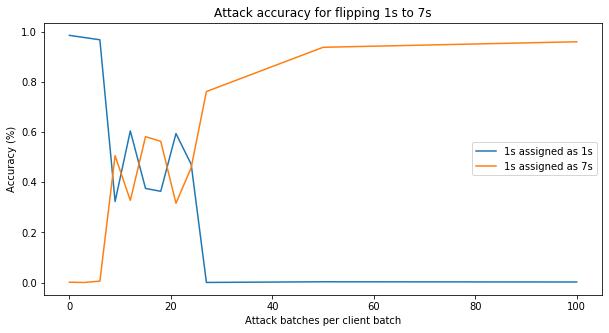

In [31]:
plt.figure()
plt.title("Attack accuracy for flipping 1s to 7s")
attacks_per_client = attack_params['attack_clients_list']
plt.plot(attacks_per_client, attack_metrics['1to7']['fail_test_accs'])
plt.plot(attacks_per_client, attack_metrics['1to7']['succ_test_accs'])

plt.legend(['1s assigned as 1s', '1s assigned as 7s'])
plt.xlabel('Attack batches per client batch')
plt.ylabel('Accuracy (%)')

plt.show()

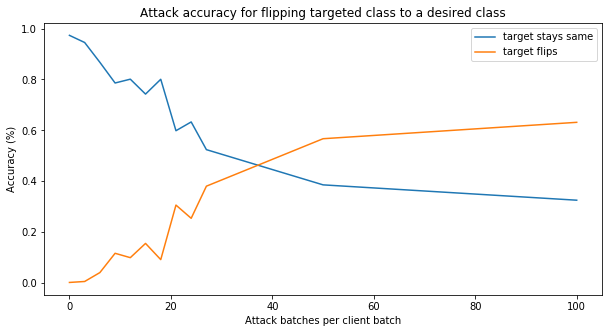

In [35]:
plt.figure()
plt.title("Attack accuracy for flipping targeted class to a desired class")
attacks_per_client = attack_params['attack_clients_list']
plt.plot(attacks_per_client, avg_fail_test_accs)
plt.plot(attacks_per_client, avg_succ_test_accs)
# plt.plot(attacks_per_client, avg_other_class_accs, 'k')

plt.legend(['target stays same', 'target flips'])#, 'model accuracy'])
plt.xlabel('Attack batches per client batch')
plt.ylabel('Accuracy (%)')

plt.show()

In [33]:
# plt.figure()
# plt.title("Attack loss for flipping 1s to 7s")
# attacks_per_client = attack_params['attack_clients_list']
# plt.plot(attacks_per_client, fail_test_losses)
# plt.plot(attacks_per_client, succ_test_losses)

# plt.legend(['1s assigned as 1s', '1s assigned as 7s'])
# plt.xlabel('Attack batches per client batch')
# plt.ylabel('Loss')

# plt.show()

In [36]:
import pickle

with open('attack_metrics.pickle', 'wb') as handle:
    pickle.dump(attack_metrics, handle, protocol=pickle.HIGHEST_PROTOCOL)